<a href="https://colab.research.google.com/github/ashwin-yedte/visual-intelligence-travel-finance/blob/main/notebooks/Step_1_Image_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Image Analysis & Feature Extraction

**Version**: 1.0  
**Author**: Ashwin Kumar Y (2023AC05628)  
**Project**: Visual Intelligence for Travel & Finance Optimization  
**Institution**: BITS Pilani  
**Date**: January 2026

---

## Overview

This notebook implements:
- Image preprocessing and validation
- CLIP-based feature extraction (512-dim embeddings)
- Zero-shot scene classification for Indian seashores
- Batch processing for 1-5 images

## Outputs
- Scene classification scores
- Visual descriptors
- Color statistics
- Dominant themes

---

In [3]:
# ============================================================================
# SETUP & INSTALLATION
# ============================================================================

print("Installing required packages...")
print("=" * 70)

# Install dependencies
!pip install -q transformers torch torchvision pillow scikit-learn

print("Installation complete!")
print("=" * 70)

# Import libraries
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import numpy as np
from typing import List, Dict, Tuple
import io
import json
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from google.colab import files
import os
import warnings
warnings.filterwarnings('ignore')

# Check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"\n PyTorch version: {torch.__version__}")
print(f" Device: {device}")
if device == "cuda":
    print(f" GPU: {torch.cuda.get_device_name(0)}")

Installing required packages...
Installation complete!

 PyTorch version: 2.9.0+cpu
 Device: cpu


Configuration **Constants**

In [5]:
"""
================================================================================
CELL 3: CONFIGURATION CONSTANTS
================================================================================
"""

print("="*80)
print("CONFIGURATION: Setting up system parameters")
print("="*80)

class Config:
    """
    Centralized configuration for the image analysis system
    """

    # Model configuration
    CLIP_MODEL_NAME = "openai/clip-vit-base-patch32"
    EMBEDDING_DIMENSION = 512

    # Image processing
    TARGET_IMAGE_SIZE = (224, 224)
    MAX_IMAGE_SIZE_MB = 10.0
    SUPPORTED_FORMATS = ['jpg', 'jpeg', 'png']

    # Batch processing
    MIN_IMAGES = 1
    MAX_IMAGES = 5

    # Color analysis
    NUM_DOMINANT_COLORS = 3
    COLOR_SAMPLE_SIZE = 10000

    # Scene classification
    TOP_K_SCENES = 5
    HIGH_CONFIDENCE_THRESHOLD = 0.75
    MEDIUM_CONFIDENCE_THRESHOLD = 0.60
    HIGH_CONFIDENCE_GAP = 0.15
    MEDIUM_CONFIDENCE_GAP = 0.10

    # Thresholds
    BRIGHTNESS_BRIGHT_THRESHOLD = 150
    BRIGHTNESS_MODERATE_THRESHOLD = 100
    THEME_CONSISTENCY_THRESHOLD = 0.5

    # Output
    OUTPUT_JSON_FILE = "step1_analysis_results.json"
    OUTPUT_VISUALIZATION_FILE = "step1_visualization.png"
    VISUALIZATION_DPI = 150

    # Metadata
    VERSION = "1.0.0"
    STEP_NAME = "Step 1: Image Analysis and Feature Extraction"
    AUTHOR = "Ashwin Kumar Y (2023AC05628)"
    PROJECT = "Visual Intelligence for Travel and Finance Optimization"

    @classmethod
    def display_config(cls):
        """Display current configuration"""
        print("\nCurrent Configuration:")
        print(f"  Model: {cls.CLIP_MODEL_NAME}")
        print(f"  Target Image Size: {cls.TARGET_IMAGE_SIZE}")
        print(f"  Max Images per Batch: {cls.MAX_IMAGES}")
        print(f"  Embedding Dimension: {cls.EMBEDDING_DIMENSION}")
        print(f"  Supported Formats: {', '.join(cls.SUPPORTED_FORMATS)}")

# Display configuration
Config.display_config()

print("\n" + "="*80)
print("CONFIGURATION COMPLETE: System parameters set")
print("="*80)


CONFIGURATION: Setting up system parameters

Current Configuration:
  Model: openai/clip-vit-base-patch32
  Target Image Size: (224, 224)
  Max Images per Batch: 5
  Embedding Dimension: 512
  Supported Formats: jpg, jpeg, png

CONFIGURATION COMPLETE: System parameters set


PROMPT **LIBRARY**

In [6]:
"""
================================================================================
CELL 4: SEASHORE PROMPT LIBRARY
================================================================================
"""

print("="*80)
print("PROMPT LIBRARY: Loading scene classification prompts")
print("="*80)

class SeashorePromptLibrary:
    """
    Collection of specialized prompts for Indian seashore scene classification.
    Organized by category for systematic theme extraction.
    """

    # Primary seashore characteristics
    PRIMARY_PROMPTS = [
        "a tropical beach with palm trees and golden sand",
        "a pristine white sand beach with clear turquoise water",
        "a rocky coastline with cliffs and crashing waves",
        "a serene beach with calm waters and gentle waves",
        "a beach with traditional fishing boats and nets",
        "a secluded cove with crystal clear water",
        "a sunset beach with orange and pink sky",
        "a beach with water sports activities and equipment",
    ]

    # Indian region-specific characteristics
    INDIAN_REGIONAL_PROMPTS = [
        "a Goa style beach with colorful shacks and palm trees",
        "a Kerala beach with coconut groves and backwaters",
        "an Andaman island beach with coral reefs and pristine water",
        "a Konkan coast beach with rocky cliffs and coconut trees",
        "a beach with traditional fishing village and local culture",
        "a beach near a temple or coastal religious site",
        "a mangrove lined coastal area with dense vegetation",
        "a Tamil Nadu beach with rocky shores",
    ]

    # Activity and atmosphere
    ACTIVITY_PROMPTS = [
        "a peaceful beach ideal for relaxation and meditation",
        "an adventure beach with water sports and activities",
        "a beach with beach parties and nightlife",
        "a family friendly beach with safe shallow waters",
        "a romantic beach with scenic sunset views",
        "an offbeat secluded beach with minimal crowds",
    ]

    # Visual aesthetics
    AESTHETIC_PROMPTS = [
        "a beach with dramatic landscape and scenic views",
        "a beach with clear blue sky and bright sunlight",
        "a beach with golden hour lighting and warm tones",
        "a beach with lush green vegetation and natural beauty",
        "a beach with unique rock formations and natural features",
    ]

    @classmethod
    def get_all_prompts(cls) -> List[str]:
        """
        Returns all prompts combined across categories.

        Returns:
            List of all prompt strings
        """
        return (cls.PRIMARY_PROMPTS +
                cls.INDIAN_REGIONAL_PROMPTS +
                cls.ACTIVITY_PROMPTS +
                cls.AESTHETIC_PROMPTS)

    @classmethod
    def get_prompt_categories(cls) -> Dict[str, List[str]]:
        """
        Returns prompts organized by category.

        Returns:
            Dictionary mapping category names to prompt lists
        """
        return {
            'primary': cls.PRIMARY_PROMPTS,
            'regional': cls.INDIAN_REGIONAL_PROMPTS,
            'activity': cls.ACTIVITY_PROMPTS,
            'aesthetic': cls.AESTHETIC_PROMPTS
        }

    @classmethod
    def get_category_for_prompt(cls, prompt: str) -> str:
        """
        Identifies which category a prompt belongs to.

        Args:
            prompt: The prompt string to categorize

        Returns:
            Category name or 'unknown'
        """
        categories = cls.get_prompt_categories()
        for category, prompts in categories.items():
            if prompt in prompts:
                return category
        return 'unknown'

    @classmethod
    def display_statistics(cls):
        """Display statistics about the prompt library"""
        categories = cls.get_prompt_categories()
        total = len(cls.get_all_prompts())

        print("\nPrompt Library Statistics:")
        print(f"  Total prompts: {total}")
        for category, prompts in categories.items():
            print(f"    {category.capitalize()}: {len(prompts)} prompts")


# Initialize and display statistics
SeashorePromptLibrary.display_statistics()

print("\n" + "="*80)
print("PROMPT LIBRARY COMPLETE: 27 specialized prompts loaded")
print("="*80)


PROMPT LIBRARY: Loading scene classification prompts

Prompt Library Statistics:
  Total prompts: 27
    Primary: 8 prompts
    Regional: 8 prompts
    Activity: 6 prompts
    Aesthetic: 5 prompts

PROMPT LIBRARY COMPLETE: 27 specialized prompts loaded


================================================================================
 IMAGE PREPROCESSOR CLASS
================================================================================
Purpose: Handles image validation, preprocessing, and feature extraction
         before feeding to the CLIP model.
================================================================================================================================


In [8]:
print("="*80)
print("IMAGE PREPROCESSOR: Initializing image processing pipeline")
print("="*80)

from typing import Any # Added this import

class ImagePreprocessor:
    """
    Comprehensive image preprocessing pipeline for beach/seashore images.

    This class handles the complete preprocessing workflow including:
    - Image validation (format, size, integrity)
    - Image standardization (resize, orientation correction)
    - Color statistics extraction
    - Dominant color identification using K-means clustering

    The preprocessor ensures all images meet the requirements for CLIP model
    input while maintaining aspect ratio and extracting useful metadata.

    Attributes:
        target_size (Tuple[int, int]): Target dimensions for resized images
        max_size_mb (float): Maximum allowed file size in megabytes
        supported_formats (List[str]): List of supported image formats

    Example:
        >>> preprocessor = ImagePreprocessor()
        >>> validation = preprocessor.validate_image(image_bytes, "beach.jpg")
        >>> if validation['valid']:
        >>>     processed_img = preprocessor.preprocess_image(image_bytes)
        >>>     color_stats = preprocessor.extract_color_statistics(processed_img)
    """

    def __init__(self,
                 target_size: Tuple[int, int] = None,
                 max_size_mb: float = None,
                 supported_formats: List[str] = None):
        """
        Initialize the ImagePreprocessor with configuration parameters.

        Args:
            target_size: Target dimensions (width, height) for resized images.
                        Defaults to Config.TARGET_IMAGE_SIZE if not provided.
            max_size_mb: Maximum file size in MB. Defaults to Config.MAX_IMAGE_SIZE_MB.
            supported_formats: List of supported formats. Defaults to Config.SUPPORTED_FORMATS.

        Note:
            Using default values from Config class ensures consistency across the system.
        """
        self.target_size = target_size or Config.TARGET_IMAGE_SIZE
        self.max_size_mb = max_size_mb or Config.MAX_IMAGE_SIZE_MB
        self.supported_formats = supported_formats or Config.SUPPORTED_FORMATS

        print(f"ImagePreprocessor initialized")
        print(f"  Target size: {self.target_size}")
        print(f"  Max file size: {self.max_size_mb} MB")
        print(f"  Supported formats: {', '.join(self.supported_formats)}")

    def validate_image(self, image_bytes: bytes, filename: str) -> Dict[str, Any]:
        """
        Validate image file before processing.

        Performs the following checks:
        1. File size validation (must be under max_size_mb)
        2. Format validation (must be in supported_formats)
        3. Integrity check (file must be readable and not corrupted)
        4. Dimension extraction

        Args:
            image_bytes: Raw image data as bytes
            filename: Original filename (used for error messages)

        Returns:
            Dictionary containing validation results with keys:
                - valid (bool): Whether image passed all validation checks
                - error (str or None): Error message if validation failed
                - size_mb (float): File size in megabytes
                - format (str or None): Image format (jpg, png, etc.)
                - dimensions (Tuple[int, int] or None): Image dimensions (width, height)

        Example:
            >>> result = preprocessor.validate_image(img_bytes, "beach.jpg")
            >>> if result['valid']:
            >>>     print(f"Valid image: {result['dimensions']}")
            >>> else:
            >>>     print(f"Invalid: {result['error']}")
        """
        # Calculate file size in megabytes
        size_mb = len(image_bytes) / (1024 * 1024)

        # Check 1: File size validation
        if size_mb > self.max_size_mb:
            return {
                'valid': False,
                'error': f"File size {size_mb:.2f}MB exceeds maximum {self.max_size_mb}MB",
                'size_mb': size_mb,
                'format': None,
                'dimensions': None
            }

        try:
            # Attempt to open image
            img = Image.open(io.BytesIO(image_bytes))

            # Extract format
            img_format = img.format.lower() if img.format else 'unknown'

            # Check 2: Format validation
            if img_format not in self.supported_formats:
                return {
                    'valid': False,
                    'error': f"Unsupported format '{img_format}'. Supported: {', '.join(self.supported_formats)}",
                    'size_mb': size_mb,
                    'format': img_format,
                    'dimensions': None
                }

            # Check 3: Integrity validation
            # verify() checks if file is readable and not corrupted
            img.verify()

            # Re-open image after verify() (verify closes the file handle)
            img = Image.open(io.BytesIO(image_bytes))

            # All checks passed
            return {
                'valid': True,
                'error': None,
                'size_mb': size_mb,
                'format': img_format,
                'dimensions': img.size  # (width, height)
            }

        except Exception as e:
            # Handle any errors during validation
            return {
                'valid': False,
                'error': f"Image validation failed: {str(e)}",
                'size_mb': size_mb,
                'format': None,
                'dimensions': None
            }

    def preprocess_image(self, image_bytes: bytes) -> Image.Image:
        """
        Preprocess image for CLIP model input.

        Performs the following operations in sequence:
        1. Load image from bytes
        2. Fix orientation using EXIF data (auto-rotate if needed)
        3. Convert to RGB color mode (handles grayscale, RGBA, etc.)
        4. Resize to target size while maintaining aspect ratio
        5. Add white padding if needed to match target dimensions

        Args:
            image_bytes: Raw image data as bytes

        Returns:
            Preprocessed PIL Image object in RGB mode with target dimensions

        Note:
            The resizing maintains aspect ratio to prevent distortion.
            White padding is added to fill remaining space.

        Example:
            >>> processed_img = preprocessor.preprocess_image(img_bytes)
            >>> print(processed_img.size)  # Should be target_size
            >>> print(processed_img.mode)  # Should be 'RGB'
        """
        # Step 1: Load image
        img = Image.open(io.BytesIO(image_bytes))

        # Step 2: Fix orientation based on EXIF data
        # Many smartphone photos have rotation info in EXIF metadata
        img = self._fix_orientation(img)

        # Step 3: Convert to RGB
        # CLIP requires RGB input, so convert if image is grayscale, RGBA, etc.
        if img.mode != 'RGB':
            img = img.convert('RGB')

        # Step 4: Resize with padding to maintain aspect ratio
        img = self._resize_with_padding(img, self.target_size)

        return img

    def _fix_orientation(self, img: Image.Image) -> Image.Image:
        """
        Fix image orientation based on EXIF metadata.

        Many images (especially from smartphones) contain EXIF orientation data
        that specifies how the image should be rotated for proper display.
        This method reads that data and auto-rotates the image if needed.

        Args:
            img: PIL Image object

        Returns:
            Image with corrected orientation

        Note:
            If EXIF processing fails (e.g., no EXIF data), returns original image.
            This is a safe operation that won't break the pipeline.
        """
        try:
            from PIL import ImageOps
            # exif_transpose automatically handles all EXIF rotation cases
            img = ImageOps.exif_transpose(img)
        except Exception:
            # If EXIF processing fails, continue with original image
            # This can happen with images that don't have EXIF data
            pass
        return img

    def _resize_with_padding(self, img: Image.Image, target_size: Tuple[int, int]) -> Image.Image:
        """
        Resize image to target size while maintaining aspect ratio.

        Algorithm:
        1. Calculate aspect ratio of input image and target size
        2. Determine scaling factor to fit image within target dimensions
        3. Resize image using high-quality LANCZOS resampling
        4. Create white canvas with target dimensions
        5. Paste resized image in center of canvas

        This approach ensures:
        - No distortion (aspect ratio preserved)
        - No cropping (entire image visible)
        - Consistent output dimensions

        Args:
            img: PIL Image to resize
            target_size: Desired output size (width, height)

        Returns:
            Resized image with white padding if needed

        Example:
            Input:  1920x1080 image, target 224x224
            Output: 224x224 image with 224x126 content and white bars top/bottom
        """
        # Calculate aspect ratios
        img_aspect_ratio = img.width / img.height
        target_aspect_ratio = target_size[0] / target_size[1]

        # Determine new dimensions based on aspect ratio
        if img_aspect_ratio > target_aspect_ratio:
            # Image is wider than target - fit to width
            new_width = target_size[0]
            new_height = int(new_width / img_aspect_ratio)
        else:
            # Image is taller than target - fit to height
            new_height = target_size[1]
            new_width = int(new_height * img_aspect_ratio)

        # Resize using high-quality LANCZOS filter
        # LANCZOS provides best quality for downsampling
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)

        # Create white canvas with target size
        canvas = Image.new('RGB', target_size, (255, 255, 255))

        # Calculate position to center the image
        offset_x = (target_size[0] - new_width) // 2
        offset_y = (target_size[1] - new_height) // 2

        # Paste resized image onto canvas
        canvas.paste(img, (offset_x, offset_y))

        return canvas

    def extract_color_statistics(self, img: Image.Image) -> Dict[str, Any]:
        """
        Extract comprehensive color statistics from image.

        Computes:
        1. Dominant colors using K-means clustering
        2. Overall brightness (mean pixel value)
        3. Color variance (measure of color diversity)

        These statistics help characterize the visual appearance:
        - Dominant colors indicate scene type (blue=water, green=vegetation, etc.)
        - Brightness helps identify time of day
        - Variance indicates visual complexity

        Args:
            img: PIL Image object

        Returns:
            Dictionary with keys:
                - dominant_colors: List of RGB triplets for top N colors
                - brightness: Mean pixel value (0-255)
                - color_variance: Variance in pixel values

        Example:
            >>> stats = preprocessor.extract_color_statistics(img)
            >>> print(f"Top color: RGB{stats['dominant_colors'][0]}")
            >>> print(f"Brightness: {stats['brightness']:.1f}")
        """
        # Convert PIL Image to numpy array for processing
        img_array = np.array(img)

        return {
            'dominant_colors': self._get_dominant_colors(img_array),
            'brightness': float(np.mean(img_array)),
            'color_variance': float(np.var(img_array))
        }

    def _get_dominant_colors(self, img_array: np.ndarray, n_colors: int = None) -> List[List[int]]:
        """
        Identify dominant colors in image using K-means clustering.

        Algorithm:
        1. Reshape image array to list of pixels (each pixel = RGB triplet)
        2. Sample pixels if image is large (for performance)
        3. Apply K-means clustering to group similar colors
        4. Sort clusters by size (frequency)
        5. Return cluster centers as dominant colors

        Args:
            img_array: Image as numpy array (height, width, 3)
            n_colors: Number of dominant colors to extract

        Returns:
            List of RGB triplets sorted by dominance
            Example: [[135, 206, 235], [255, 245, 200], [34, 139, 34]]
                     (sky blue,       sand beige,      vegetation green)

        Note:
            For performance, limits analysis to 10,000 random pixels
            if image is larger. This provides good approximation while
            maintaining fast execution.
        """
        n_colors = n_colors or Config.NUM_DOMINANT_COLORS

        # Reshape from (height, width, 3) to (num_pixels, 3)
        pixels = img_array.reshape(-1, 3)

        # Sample pixels if too many (for performance)
        if len(pixels) > Config.COLOR_SAMPLE_SIZE:
            # Randomly sample pixels
            indices = np.random.choice(len(pixels), Config.COLOR_SAMPLE_SIZE, replace=False)
            pixels = pixels[indices]

        # Apply K-means clustering
        # n_init=10 means algorithm runs 10 times with different initializations
        # and picks best result (more stable than default)
        kmeans = KMeans(n_clusters=n_colors, random_state=42, n_init=10)
        kmeans.fit(pixels)

        # Get cluster centers (these are our dominant colors)
        colors = kmeans.cluster_centers_.astype(int)

        # Get cluster assignments for each pixel
        labels = kmeans.labels_

        # Count pixels in each cluster
        counts = np.bincount(labels)

        # Sort colors by frequency (most common first)
        sorted_indices = np.argsort(-counts)  # Negative for descending order
        dominant_colors = colors[sorted_indices].tolist()

        return dominant_colors


# Initialize the preprocessor
print("\nInitializing ImagePreprocessor...")
preprocessor = ImagePreprocessor()

print("\n" + "="*80)
print("IMAGE PREPROCESSOR COMPLETE: Ready to process images")
print("="*80)


IMAGE PREPROCESSOR: Initializing image processing pipeline

Initializing ImagePreprocessor...
ImagePreprocessor initialized
  Target size: (224, 224)
  Max file size: 10.0 MB
  Supported formats: jpg, jpeg, png

IMAGE PREPROCESSOR COMPLETE: Ready to process images


================================================================================
CLIP FEATURE EXTRACTOR CLASS
================================================================================
Purpose: Handles CLIP model loading and embedding generation for images and text.
         Core component for zero-shot scene classification.
================================================================================

In [9]:

print("="*80)
print("CLIP FEATURE EXTRACTOR: Loading vision-language model")
print("="*80)

class CLIPFeatureExtractor:
    """
    CLIP (Contrastive Language-Image Pre-training) Feature Extractor.

    This class manages the CLIP model for generating semantic embeddings from
    both images and text. CLIP was trained to understand the relationship between
    images and their textual descriptions, making it ideal for zero-shot
    classification tasks.

    Key Capabilities:
    - Generate 512-dimensional embeddings for images
    - Generate 512-dimensional embeddings for text prompts
    - Compute similarity between image and text embeddings
    - Zero-shot classification without fine-tuning

    Architecture:
    - Uses OpenAI's CLIP ViT-B/32 model (Vision Transformer Base, patch size 32)
    - Model has 151M parameters
    - Trained on 400M image-text pairs
    - Output embeddings are L2-normalized for cosine similarity

    Attributes:
        device (str): Computation device ('cuda' or 'cpu')
        model (CLIPModel): The loaded CLIP model
        processor (CLIPProcessor): Handles input preprocessing
        model_name (str): HuggingFace model identifier

    Example:
        >>> extractor = CLIPFeatureExtractor()
        >>> img_embedding = extractor.generate_image_embedding(image)
        >>> text_embeddings = extractor.generate_text_embeddings(["beach", "mountain"])
        >>> similarities = extractor.compute_similarity(img_embedding, text_embeddings)
    """

    def __init__(self, model_name: str = None):
        """
        Initialize CLIP model and processor.

        Loads the pre-trained CLIP model from HuggingFace and moves it to
        the appropriate device (GPU if available, otherwise CPU). Sets model
        to evaluation mode for inference.

        Args:
            model_name: HuggingFace model identifier. Defaults to Config.CLIP_MODEL_NAME.
                       Options include:
                       - "openai/clip-vit-base-patch32" (default, balanced)
                       - "openai/clip-vit-base-patch16" (higher accuracy, slower)
                       - "openai/clip-vit-large-patch14" (best accuracy, much slower)

        Note:
            First run will download model (~600MB for base model).
            Subsequent runs load from cache.

            GPU is highly recommended for better performance:
            - With GPU: ~0.1-0.2 seconds per image
            - With CPU: ~1-2 seconds per image

        Raises:
            RuntimeError: If model fails to load
        """
        self.model_name = model_name or Config.CLIP_MODEL_NAME
        self.device = "cuda" if torch.cuda.is_available() else "cpu"

        print(f"\nLoading CLIP model: {self.model_name}")
        print(f"Target device: {self.device}")

        try:
            # Load pre-trained model
            print("  Downloading/Loading model weights...")
            self.model = CLIPModel.from_pretrained(self.model_name)

            # Move model to device (GPU or CPU)
            self.model = self.model.to(self.device)

            # Load processor for input preprocessing
            print("  Loading processor...")
            self.processor = CLIPProcessor.from_pretrained(self.model_name)

            # Set model to evaluation mode (disables dropout, batch norm training mode)
            self.model.eval()

            # Calculate model size
            num_params = sum(p.numel() for p in self.model.parameters())
            print(f"\nModel loaded successfully!")
            print(f"  Parameters: {num_params:,}")
            print(f"  Device: {self.device}")
            print(f"  Embedding dimension: {Config.EMBEDDING_DIMENSION}")

        except Exception as e:
            raise RuntimeError(f"Failed to load CLIP model: {str(e)}")

    def generate_image_embedding(self, image: Image.Image) -> np.ndarray:
        """
        Generate semantic embedding for a single image.

        Process:
        1. Preprocess image (resize, normalize using CLIP's preprocessing)
        2. Convert to tensor and move to device
        3. Forward pass through CLIP's vision encoder
        4. Extract image features from final layer
        5. L2-normalize embedding (required for cosine similarity)
        6. Convert to numpy array

        The resulting embedding captures semantic meaning of the image in a
        512-dimensional vector space. Similar images have embeddings close
        together in this space.

        Args:
            image: PIL Image object (any size, will be resized by processor)

        Returns:
            numpy array of shape (512,) containing normalized embedding
            Values are float32 in range approximately [-1, 1]

        Mathematical Details:
            Given image I, compute embedding e:
                e_raw = VisionEncoder(I)
                e = e_raw / ||e_raw||_2

            Where ||.||_2 is the L2 norm (Euclidean length).
            This normalization ensures cosine similarity = dot product.

        Performance:
            - GPU: ~0.1-0.2 seconds per image
            - CPU: ~1-2 seconds per image

        Example:
            >>> from PIL import Image
            >>> img = Image.open("beach.jpg")
            >>> embedding = extractor.generate_image_embedding(img)
            >>> print(embedding.shape)  # (512,)
            >>> print(np.linalg.norm(embedding))  # ~1.0 (normalized)
        """
        # Preprocess image using CLIP's processor
        # This handles: resize to 224x224, convert to tensor, normalize
        inputs = self.processor(images=image, return_tensors="pt")

        # Move inputs to same device as model
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Generate embedding with no gradient computation (inference only)
        with torch.no_grad():
            # Forward pass through vision encoder
            image_features = self.model.get_image_features(**inputs)

        # L2-normalize embedding
        # Formula: e_norm = e / sqrt(sum(e^2))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        # Convert to numpy and flatten to 1D array
        embedding = image_features.cpu().numpy().flatten()

        return embedding

    def generate_text_embeddings(self, text_prompts: List[str]) -> np.ndarray:
        """
        Generate semantic embeddings for multiple text prompts.

        Process:
        1. Tokenize text using CLIP's tokenizer
        2. Pad/truncate to max length (77 tokens for CLIP)
        3. Convert to tensors and move to device
        4. Forward pass through CLIP's text encoder
        5. Extract text features from final layer
        6. L2-normalize embeddings
        7. Convert to numpy array

        Text embeddings live in the same 512-dimensional space as image
        embeddings, enabling direct comparison via cosine similarity.

        Args:
            text_prompts: List of text descriptions
                         Example: ["a beach with palm trees", "a mountain landscape"]

        Returns:
            numpy array of shape (num_prompts, 512)
            Each row is a normalized embedding for one prompt

        Mathematical Details:
            For each prompt p_i, compute embedding t_i:
                t_raw = TextEncoder(p_i)
                t_i = t_raw / ||t_raw||_2

        Performance:
            Batch processing is efficient:
            - 27 prompts: ~0.5 seconds on GPU, ~2-3 seconds on CPU

        Note:
            CLIP's text encoder has a maximum length of 77 tokens.
            Longer texts are truncated, shorter texts are padded.

        Example:
            >>> prompts = ["a tropical beach", "a rocky coastline", "a sunset"]
            >>> embeddings = extractor.generate_text_embeddings(prompts)
            >>> print(embeddings.shape)  # (3, 512)
            >>> print(np.linalg.norm(embeddings[0]))  # ~1.0
        """
        # Tokenize and preprocess text
        # padding=True ensures all prompts have same length
        inputs = self.processor(
            text=text_prompts,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=77  # CLIP's maximum sequence length
        )

        # Move inputs to device
        inputs = {k: v.to(self.device) for k, v in inputs.items()}

        # Generate embeddings with no gradient computation
        with torch.no_grad():
            # Forward pass through text encoder
            text_features = self.model.get_text_features(**inputs)

        # L2-normalize embeddings
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Convert to numpy
        embeddings = text_features.cpu().numpy()

        return embeddings

    def compute_similarity(self,
                          image_embedding: np.ndarray,
                          text_embeddings: np.ndarray) -> np.ndarray:
        """
        Compute cosine similarity between image and text embeddings.

        Since both embeddings are L2-normalized, cosine similarity simplifies
        to dot product. This measures semantic similarity in the shared
        embedding space.

        Mathematical Definition:
            For normalized vectors u and v:
            cosine_similarity(u, v) = (u · v) / (||u|| * ||v||)
                                    = u · v  (when normalized)

        Interpretation of Similarity Scores:
            > 0.7  : High similarity (strong match)
            0.5-0.7: Medium similarity (moderate match)
            0.3-0.5: Low similarity (weak match)
            < 0.3  : Very low similarity (poor match)

        Args:
            image_embedding: Single image embedding of shape (512,)
            text_embeddings: Multiple text embeddings of shape (num_prompts, 512)

        Returns:
            numpy array of shape (num_prompts,) containing similarity scores
            Values range from -1 (opposite) to +1 (identical)
            In practice, values typically range from 0.2 to 0.9

        Implementation:
            similarities[i] = sum(text_embeddings[i] * image_embedding)

            This is equivalent to matrix-vector multiplication:
            similarities = text_embeddings @ image_embedding

        Example:
            >>> img_emb = extractor.generate_image_embedding(beach_image)
            >>> text_embs = extractor.generate_text_embeddings([
            ...     "a tropical beach",
            ...     "a mountain peak",
            ...     "an urban street"
            ... ])
            >>> similarities = extractor.compute_similarity(img_emb, text_embs)
            >>> print(similarities)  # [0.85, 0.32, 0.28] - beach matches best
        """
        # Compute dot product (cosine similarity for normalized vectors)
        # Broadcasting: (num_prompts, 512) @ (512,) -> (num_prompts,)
        similarities = np.dot(text_embeddings, image_embedding)

        return similarities

    def get_model_info(self) -> Dict[str, Any]:
        """
        Get information about the loaded model.

        Returns:
            Dictionary containing model metadata:
                - model_name: HuggingFace identifier
                - device: Computation device
                - num_parameters: Total trainable parameters
                - embedding_dim: Output embedding dimension
                - vision_config: Vision encoder settings
                - text_config: Text encoder settings
        """
        num_params = sum(p.numel() for p in self.model.parameters())

        return {
            'model_name': self.model_name,
            'device': self.device,
            'num_parameters': num_params,
            'embedding_dim': Config.EMBEDDING_DIMENSION,
            'vision_patch_size': self.model.config.vision_config.patch_size,
            'text_max_length': self.model.config.text_config.max_position_embeddings
        }


# Initialize CLIP feature extractor
print("\n" + "="*80)
print("Initializing CLIP Feature Extractor...")
print("="*80)

feature_extractor = CLIPFeatureExtractor()

# Display model information
model_info = feature_extractor.get_model_info()
print("\nModel Information:")
print(f"  Vision patch size: {model_info['vision_patch_size']}")
print(f"  Text max length: {model_info['text_max_length']} tokens")

print("\n" + "="*80)
print("CLIP FEATURE EXTRACTOR COMPLETE: Ready for embedding generation")
print("="*80)

CLIP FEATURE EXTRACTOR: Loading vision-language model

Initializing CLIP Feature Extractor...

Loading CLIP model: openai/clip-vit-base-patch32
Target device: cpu
  Downloading/Loading model weights...


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


  Loading processor...


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]


Model loaded successfully!
  Parameters: 151,277,313
  Device: cpu
  Embedding dimension: 512

Model Information:
  Vision patch size: 32
  Text max length: 77 tokens

CLIP FEATURE EXTRACTOR COMPLETE: Ready for embedding generation


================================================================================
 SCENE CLASSIFIER **CLASS**
================================================================================
Purpose: Orchestrates the complete scene classification pipeline using CLIP.
         Combines preprocessing, embedding generation, and similarity scoring.
         
================================================================================

In [10]:
print("="*80)
print("SCENE CLASSIFIER: Initializing classification pipeline")
print("="*80)

class SeashoreSceneClassifier:
    """
    Complete scene classification pipeline for seashore images.

    This class orchestrates the entire analysis workflow by combining:
    - Image preprocessing (validation, resizing, color analysis)
    - CLIP feature extraction (embedding generation)
    - Zero-shot classification (prompt matching)
    - Confidence scoring and descriptor extraction

    The classifier uses pre-computed text embeddings for efficiency,
    computing them once during initialization and reusing for all images.

    Workflow:
        1. Validate image (size, format, integrity)
        2. Preprocess image (resize, normalize, orientation)
        3. Extract color statistics (dominant colors, brightness)
        4. Generate image embedding (512-dim vector)
        5. Compare with text embeddings (cosine similarity)
        6. Rank scenes by similarity
        7. Compute confidence score
        8. Extract visual descriptors

    Attributes:
        preprocessor (ImagePreprocessor): Handles image preprocessing
        feature_extractor (CLIPFeatureExtractor): Generates embeddings
        prompt_library (SeashorePromptLibrary): Provides scene prompts
        text_embeddings (np.ndarray): Pre-computed prompt embeddings
        prompts (List[str]): List of all prompts

    Example:
        >>> classifier = SeashoreSceneClassifier()
        >>> result = classifier.analyze_single_image(image_bytes, "beach1")
        >>> print(result['top_scenes'][0]['prompt'])
        >>> print(result['confidence'])
    """

    def __init__(self):
        """
        Initialize scene classifier with all required components.

        This constructor performs the following setup:
        1. Creates image preprocessor instance
        2. Creates CLIP feature extractor instance
        3. Loads prompt library
        4. Pre-computes text embeddings for all prompts

        The text embeddings are computed once here and cached for reuse,
        making subsequent image analysis much faster since we only need
        to compute image embeddings.

        Time Complexity:
            - With GPU: ~1 second for 27 prompts
            - With CPU: ~3-5 seconds for 27 prompts

        Note:
            Pre-computing text embeddings is a key optimization.
            For N images and M prompts:
            - Without caching: N * M embedding computations
            - With caching: M + N embedding computations
        """
        print("\nInitializing classifier components...")

        # Component 1: Image preprocessor
        print("  Creating image preprocessor...")
        self.preprocessor = ImagePreprocessor()

        # Component 2: CLIP feature extractor
        print("  Creating CLIP feature extractor...")
        self.feature_extractor = CLIPFeatureExtractor()

        # Component 3: Prompt library
        print("  Loading prompt library...")
        self.prompt_library = SeashorePromptLibrary()

        # Component 4: Pre-compute text embeddings
        all_prompts = self.prompt_library.get_all_prompts()
        num_prompts = len(all_prompts)

        print(f"\n  Pre-computing text embeddings for {num_prompts} prompts...")
        print("  This may take 3-5 seconds on CPU...")

        self.text_embeddings = self.feature_extractor.generate_text_embeddings(all_prompts)
        self.prompts = all_prompts

        print(f"  Text embeddings computed: shape {self.text_embeddings.shape}")
        print("\nClassifier initialization complete!")

    def analyze_single_image(self, image_bytes: bytes, image_id: str) -> Dict[str, Any]:
        """
        Perform complete analysis on a single image.

        This is the main entry point for image analysis. It executes the
        complete pipeline and returns comprehensive results including scene
        classifications, confidence scores, and visual descriptors.

        Pipeline Steps:
            Step 1: Validate image (check size, format, integrity)
            Step 2: Preprocess image (resize, normalize, fix orientation)
            Step 3: Extract color statistics (K-means clustering)
            Step 4: Generate image embedding (CLIP vision encoder)
            Step 5: Compute similarities (dot product with text embeddings)
            Step 6: Rank scenes (sort by similarity score)
            Step 7: Compute confidence (based on top scores and gap)
            Step 8: Extract descriptors (human-readable characteristics)

        Args:
            image_bytes: Raw image data as bytes
            image_id: Identifier for this image (e.g., filename without extension)

        Returns:
            Dictionary containing complete analysis results:
            {
                'image_id': str,
                'success': bool,
                'error': str or None,  # Only present if success=False
                'embedding': List[float],  # 512-dim vector
                'scene_scores': Dict[str, float],  # All prompt scores
                'top_scenes': List[Dict],  # Top K scenes with details
                'visual_descriptors': Dict,  # Human-readable characteristics
                'color_statistics': Dict,  # Dominant colors, brightness
                'confidence': str,  # 'high', 'medium', or 'low'
                'dimensions': Tuple[int, int]  # Original image size
            }

        Error Handling:
            If validation fails, returns:
            {
                'image_id': str,
                'success': False,
                'error': str  # Description of what went wrong
            }

        Performance:
            - GPU: ~0.5 seconds per image
            - CPU: ~2-3 seconds per image

        Example:
            >>> with open('beach.jpg', 'rb') as f:
            >>>     img_bytes = f.read()
            >>> result = classifier.analyze_single_image(img_bytes, "beach1")
            >>>
            >>> if result['success']:
            >>>     print(f"Top scene: {result['top_scenes'][0]['prompt']}")
            >>>     print(f"Confidence: {result['confidence']}")
            >>> else:
            >>>     print(f"Error: {result['error']}")
        """
        # Step 1: Validate image
        validation = self.preprocessor.validate_image(image_bytes, image_id)

        if not validation['valid']:
            # Return early if validation fails
            return {
                'image_id': image_id,
                'error': validation['error'],
                'success': False
            }

        # Step 2: Preprocess image
        processed_image = self.preprocessor.preprocess_image(image_bytes)

        # Step 3: Extract color statistics
        color_stats = self.preprocessor.extract_color_statistics(processed_image)

        # Step 4: Generate image embedding
        image_embedding = self.feature_extractor.generate_image_embedding(processed_image)

        # Step 5: Compute similarities with all prompts
        similarities = self.feature_extractor.compute_similarity(
            image_embedding,
            self.text_embeddings
        )

        # Step 6: Create scene scores dictionary (prompt -> score mapping)
        scene_scores = {
            prompt: float(score)
            for prompt, score in zip(self.prompts, similarities)
        }

        # Step 7: Get top K scenes (sorted by score, descending)
        top_k = Config.TOP_K_SCENES
        top_indices = np.argsort(similarities)[-top_k:][::-1]  # Top K descending

        top_scenes = [
            {
                'prompt': self.prompts[idx],
                'score': float(similarities[idx]),
                'category': self._get_prompt_category(self.prompts[idx])
            }
            for idx in top_indices
        ]

        # Step 8: Compute confidence level
        top_score = similarities[top_indices[0]]
        second_score = similarities[top_indices[1]]
        confidence = self._compute_confidence(top_score, second_score)

        # Step 9: Extract visual descriptors
        descriptors = self._extract_descriptors(top_scenes, color_stats)

        # Return complete analysis
        return {
            'image_id': image_id,
            'success': True,
            'embedding': image_embedding.tolist(),  # Convert numpy to list for JSON
            'scene_scores': scene_scores,
            'top_scenes': top_scenes,
            'visual_descriptors': descriptors,
            'color_statistics': color_stats,
            'confidence': confidence,
            'dimensions': validation['dimensions']
        }

    def _get_prompt_category(self, prompt: str) -> str:
        """
        Identify which category a prompt belongs to.

        Categories help organize results and provide context for why
        certain prompts matched. For example, a 'regional' category match
        suggests geographic specificity.

        Args:
            prompt: The prompt string to categorize

        Returns:
            Category name: 'primary', 'regional', 'activity', 'aesthetic', or 'unknown'

        Example:
            >>> category = classifier._get_prompt_category(
            ...     "a Goa style beach with colorful shacks"
            ... )
            >>> print(category)  # 'regional'
        """
        return self.prompt_library.get_category_for_prompt(prompt)

    def _compute_confidence(self, top_score: float, second_score: float) -> str:
        """
        Compute confidence level based on top similarity scores.

        Confidence depends on two factors:
        1. Absolute score of top match (how good is the best match?)
        2. Score gap between top two matches (how clear is the winner?)

        Rationale:
        - High score + large gap = very confident classification
        - High score + small gap = multiple plausible scenes
        - Low score = poor match overall

        Thresholds:
        - High confidence:
            * Top score > 0.75 (strong match)
            * Gap > 0.15 (clear winner)
        - Medium confidence:
            * Top score > 0.60 (decent match)
            * Gap > 0.10 (reasonable separation)
        - Low confidence:
            * Otherwise (ambiguous or poor matches)

        Args:
            top_score: Similarity score of best matching prompt
            second_score: Similarity score of second-best matching prompt

        Returns:
            Confidence level: 'high', 'medium', or 'low'

        Example:
            >>> conf = classifier._compute_confidence(0.85, 0.65)
            >>> print(conf)  # 'high' (score=0.85>0.75, gap=0.20>0.15)
            >>>
            >>> conf = classifier._compute_confidence(0.72, 0.68)
            >>> print(conf)  # 'medium' (score ok, but gap=0.04<0.10)
        """
        score_gap = top_score - second_score

        # High confidence: strong match with clear separation
        if top_score > Config.HIGH_CONFIDENCE_THRESHOLD and score_gap > Config.HIGH_CONFIDENCE_GAP:
            return 'high'

        # Medium confidence: decent match with reasonable separation
        elif top_score > Config.MEDIUM_CONFIDENCE_THRESHOLD and score_gap > Config.MEDIUM_CONFIDENCE_GAP:
            return 'medium'

        # Low confidence: weak match or ambiguous (multiple similar scores)
        else:
            return 'low'

    def _extract_descriptors(self,
                           top_scenes: List[Dict],
                           color_stats: Dict) -> Dict[str, Any]:
        """
        Extract human-readable visual descriptors from analysis results.

        Converts technical analysis results into natural language descriptions
        that help users understand the image characteristics. This includes:
        - Primary and secondary themes
        - Dominant colors (as RGB values)
        - Brightness level (bright/moderate/dark)
        - Inferred characteristics (water quality, terrain, vegetation, etc.)

        Characteristic Inference:
        Uses keyword matching in top scene prompts to infer visual features:
        - "pristine"/"clear" -> pristine water quality
        - "rocky"/"cliff" -> rocky terrain
        - "palm"/"coconut" -> tropical vegetation
        - "fishing"/"boat" -> local fishing culture
        - "sunset"/"golden hour" -> sunset ambiance
        - "goa" -> Goa-style beach
        - "kerala"/"backwater" -> Kerala backwaters influence
        - "andaman"/"coral" -> island paradise

        Args:
            top_scenes: List of top matching scenes with prompts and scores
            color_stats: Dictionary with color analysis results

        Returns:
            Dictionary containing:
            {
                'primary_theme': str,  # Best matching prompt
                'secondary_themes': List[str],  # Next 2 best prompts
                'dominant_colors_rgb': List[List[int]],  # Top 3 colors
                'brightness_level': str,  # 'bright', 'moderate', or 'dark'
                'characteristics': List[str]  # Inferred features
            }

        Example:
            >>> descriptors = classifier._extract_descriptors(
            ...     top_scenes=[
            ...         {'prompt': 'a pristine white sand beach', 'score': 0.85},
            ...         {'prompt': 'a tropical beach with palms', 'score': 0.78}
            ...     ],
            ...     color_stats={'dominant_colors': [[135,206,235]], 'brightness': 165}
            ... )
            >>> print(descriptors['characteristics'])
            >>> # ['pristine water quality', 'tropical vegetation']
        """
        descriptors = {
            'primary_theme': top_scenes[0]['prompt'],
            'secondary_themes': [scene['prompt'] for scene in top_scenes[1:3]],
            'dominant_colors_rgb': color_stats['dominant_colors'],
            'brightness_level': self._classify_brightness(color_stats['brightness']),
        }

        # Infer characteristics from top scene prompts
        all_top_text = ' '.join([s['prompt'] for s in top_scenes]).lower()

        characteristics = []

        # Water quality
        if 'pristine' in all_top_text or 'clear' in all_top_text:
            characteristics.append('pristine water quality')

        # Terrain type
        if 'rocky' in all_top_text or 'cliff' in all_top_text:
            characteristics.append('rocky terrain')

        # Vegetation
        if 'palm' in all_top_text or 'coconut' in all_top_text:
            characteristics.append('tropical vegetation')

        # Cultural elements
        if 'fishing' in all_top_text or 'boat' in all_top_text:
            characteristics.append('local fishing culture')

        # Time of day
        if 'sunset' in all_top_text or 'golden hour' in all_top_text:
            characteristics.append('sunset ambiance')

        # Regional characteristics
        if 'goa' in all_top_text:
            characteristics.append('Goa-style beach')

        if 'kerala' in all_top_text or 'backwater' in all_top_text:
            characteristics.append('Kerala backwaters influence')

        if 'andaman' in all_top_text or 'coral' in all_top_text:
            characteristics.append('island paradise')

        if 'konkan' in all_top_text:
            characteristics.append('Konkan coast features')

        if 'mangrove' in all_top_text:
            characteristics.append('mangrove ecosystem')

        descriptors['characteristics'] = characteristics

        return descriptors

    def _classify_brightness(self, brightness: float) -> str:
        """
        Classify brightness level based on mean pixel value.

        Brightness categories help understand lighting conditions:
        - Bright: Well-lit, sunny conditions (beach at midday)
        - Moderate: Overcast or morning/evening light
        - Dark: Low light conditions (dusk, indoor)

        Thresholds based on typical image statistics:
        - Bright: mean > 150 (out of 255)
        - Moderate: mean 100-150
        - Dark: mean < 100

        Args:
            brightness: Mean pixel value across all channels (0-255 scale)

        Returns:
            Brightness category: 'bright', 'moderate', or 'dark'

        Example:
            >>> level = classifier._classify_brightness(165.3)
            >>> print(level)  # 'bright'
        """
        if brightness > Config.BRIGHTNESS_BRIGHT_THRESHOLD:
            return 'bright'
        elif brightness > Config.BRIGHTNESS_MODERATE_THRESHOLD:
            return 'moderate'
        else:
            return 'dark'


# Initialize scene classifier
print("\n" + "="*80)
print("Initializing Scene Classifier...")
print("="*80)

classifier = SeashoreSceneClassifier()

print("\n" + "="*80)
print("SCENE CLASSIFIER COMPLETE: Ready to analyze images")
print("="*80)

SCENE CLASSIFIER: Initializing classification pipeline

Initializing Scene Classifier...

Initializing classifier components...
  Creating image preprocessor...
ImagePreprocessor initialized
  Target size: (224, 224)
  Max file size: 10.0 MB
  Supported formats: jpg, jpeg, png
  Creating CLIP feature extractor...

Loading CLIP model: openai/clip-vit-base-patch32
Target device: cpu
  Downloading/Loading model weights...
  Loading processor...

Model loaded successfully!
  Parameters: 151,277,313
  Device: cpu
  Embedding dimension: 512
  Loading prompt library...

  Pre-computing text embeddings for 27 prompts...
  This may take 3-5 seconds on CPU...
  Text embeddings computed: shape (27, 512)

Classifier initialization complete!

SCENE CLASSIFIER COMPLETE: Ready to analyze images


================================================================================
BATCH PROCESSOR CLASS
================================================================================
Purpose: Process multiple images (1-5) and compute aggregate statistics.
         Handles batch validation, individual analysis, and theme consistency.

================================================================================

In [11]:
"""
================================================================================
CELL 8: BATCH PROCESSOR CLASS
================================================================================
Purpose: Process multiple images (1-5) and compute aggregate statistics.
         Handles batch validation, individual analysis, and theme consistency.
================================================================================
"""

print("="*80)
print("BATCH PROCESSOR: Initializing multi-image processing pipeline")
print("="*80)

class ImageBatchProcessor:
    """
    Batch processor for analyzing multiple seashore images.

    This class orchestrates the analysis of 1-5 images and computes
    aggregate statistics across the batch. It identifies consistent themes
    that appear across multiple images, which is crucial for Step 2
    (Theme Extraction).

    Key Features:
    - Validates batch size (1-5 images)
    - Processes each image independently
    - Computes cross-image theme consistency
    - Identifies dominant themes across the batch
    - Tracks theme appearance frequency

    The batch statistics output serves as input for Step 2, where
    we extract the final theme profile considering multi-image consistency.

    Attributes:
        classifier (SeashoreSceneClassifier): Scene classifier instance

    Example:
        >>> processor = ImageBatchProcessor()
        >>> image_files = [
        ...     {'image_id': 'beach1', 'image_bytes': bytes1},
        ...     {'image_id': 'beach2', 'image_bytes': bytes2}
        ... ]
        >>> results = processor.process_batch(image_files)
        >>> print(results['batch_statistics']['theme_consistency'])
    """

    def __init__(self):
        """
        Initialize batch processor with scene classifier.

        Creates a single scene classifier instance that will be reused
        for all images in the batch. This is efficient because the CLIP
        model and text embeddings are loaded once and shared.

        Note:
            The scene classifier is already initialized with pre-computed
            text embeddings, so processing multiple images only requires
            computing image embeddings (fast operation).
        """
        print("\nInitializing batch processor...")
        print("  Creating scene classifier instance...")
        self.classifier = SeashoreSceneClassifier()
        print("\nBatch processor ready!")

    def process_batch(self, image_files: List[Dict[str, Any]]) -> Dict[str, Any]:
        """
        Process a batch of 1-5 images and compute aggregate statistics.

        Workflow:
        1. Validate batch size (1-5 images)
        2. Validate non-empty batch
        3. Process each image individually
        4. Collect successful analyses
        5. Compute batch statistics (if multiple images)
        6. Return comprehensive results

        The batch statistics include:
        - Average scene scores across all images
        - Theme consistency metrics (how often themes appear)
        - Standard deviation of scores (variability measure)
        - Theme appearance counts

        Args:
            image_files: List of dictionaries, each containing:
                {
                    'image_id': str,       # Unique identifier
                    'image_bytes': bytes,  # Raw image data
                    'filename': str        # Optional, original filename
                }

        Returns:
            Dictionary containing:
            {
                'success': bool,               # Overall batch success
                'error': str or None,          # Error if batch validation fails
                'num_images': int,             # Number of images in batch
                'per_image_analysis': Dict,    # Results for each image
                'batch_statistics': Dict       # Aggregate statistics
            }

            If success=False (validation error):
            {
                'success': False,
                'error': str  # Description of validation error
            }

        Validation Rules:
        - Minimum images: 1 (Config.MIN_IMAGES)
        - Maximum images: 5 (Config.MAX_IMAGES)
        - Empty batch returns error

        Performance:
        - GPU: ~0.5 seconds per image + ~0.1 seconds for statistics
        - CPU: ~2-3 seconds per image + ~0.1 seconds for statistics

        Example:
            >>> image_files = [
            ...     {'image_id': 'img1', 'image_bytes': data1},
            ...     {'image_id': 'img2', 'image_bytes': data2},
            ...     {'image_id': 'img3', 'image_bytes': data3}
            ... ]
            >>> results = processor.process_batch(image_files)
            >>>
            >>> if results['success']:
            ...     print(f"Analyzed {results['num_images']} images")
            ...     for img_id, analysis in results['per_image_analysis'].items():
            ...         if analysis.get('success'):
            ...             print(f"{img_id}: {analysis['confidence']}")
        """
        # Validation 1: Check maximum batch size
        if len(image_files) > Config.MAX_IMAGES:
            return {
                'success': False,
                'error': f'Maximum {Config.MAX_IMAGES} images allowed, received {len(image_files)}'
            }

        # Validation 2: Check minimum batch size
        if len(image_files) < Config.MIN_IMAGES:
            return {
                'success': False,
                'error': f'Minimum {Config.MIN_IMAGES} image required, received {len(image_files)}'
            }

        # Initialize results structure
        results = {
            'success': True,
            'num_images': len(image_files),
            'per_image_analysis': {},
            'batch_statistics': {}
        }

        # Track successful analyses for statistics computation
        successful_analyses = []

        # Display batch processing header
        print("\n" + "="*80)
        print(f"BATCH PROCESSING: Analyzing {len(image_files)} image(s)")
        print("="*80)

        # Process each image
        for i, img_file in enumerate(image_files, 1):
            image_id = img_file['image_id']

            print(f"\nImage {i}/{len(image_files)}: {image_id}")
            print("-" * 80)

            # Analyze single image
            analysis = self.classifier.analyze_single_image(
                img_file['image_bytes'],
                image_id
            )

            # Store result
            results['per_image_analysis'][image_id] = analysis

            # Display result summary
            if analysis['success']:
                successful_analyses.append(analysis)
                top_scene = analysis['top_scenes'][0]
                print(f"  Status: Success")
                print(f"  Confidence: {analysis['confidence']}")
                print(f"  Top theme: {top_scene['prompt'][:60]}...")
                print(f"  Score: {top_scene['score']:.3f}")
            else:
                print(f"  Status: Failed")
                print(f"  Error: {analysis['error']}")

        # Compute batch statistics if we have successful analyses
        if successful_analyses:
            print("\n" + "-"*80)
            print("Computing batch statistics...")
            results['batch_statistics'] = self._compute_batch_statistics(successful_analyses)
            print("Batch statistics complete!")

        print("\n" + "="*80)
        print(f"BATCH PROCESSING COMPLETE: {len(successful_analyses)}/{len(image_files)} successful")
        print("="*80)

        return results

    def _compute_batch_statistics(self, analyses: List[Dict[str, Any]]) -> Dict[str, Any]:
        """
        Compute aggregate statistics across multiple image analyses.

        This method identifies themes that consistently appear across images,
        which is critical for extracting the user's true preferences. A theme
        that appears in 3 out of 3 images is much more reliable than one that
        appears in only 1 image.

        Computed Metrics:

        1. Average Scene Scores:
           - Mean similarity score for each prompt across all images
           - Indicates overall relevance of each theme

        2. Theme Consistency:
           For each prompt, computes:
           - avg_score: Mean similarity across images
           - std_score: Standard deviation (measures variability)
           - max_score: Highest score achieved
           - min_score: Lowest score achieved
           - appears_in_top5: Count of images where score > threshold
           - consistency: Fraction of images with high score

        3. Ranking:
           - Themes sorted by consistency first, then avg_score
           - High consistency + high score = strong theme

        Args:
            analyses: List of successful analysis results from individual images

        Returns:
            Dictionary containing:
            {
                'average_scene_scores': Dict[str, float],
                'theme_consistency': Dict[str, Dict],
                'total_images_analyzed': int
            }

            Where theme_consistency values are:
            {
                'prompt_text': {
                    'avg_score': float,      # Mean across images
                    'std_score': float,      # Standard deviation
                    'max_score': float,      # Best score
                    'min_score': float,      # Worst score
                    'appears_in_top5': int,  # Count of high scores
                    'consistency': float     # Fraction in [0, 1]
                }
            }

        Statistical Interpretation:

        - High consistency (>0.7): Strong theme across most/all images
        - Medium consistency (0.4-0.7): Theme in some images
        - Low consistency (<0.4): Weak or inconsistent theme

        - Low std_score: Stable scores across images (reliable)
        - High std_score: Variable scores (less reliable)

        Example:
            Given 3 images analyzing "tropical beach":

            Image 1 score: 0.85
            Image 2 score: 0.82
            Image 3 score: 0.88

            Results:
            - avg_score: 0.85
            - std_score: 0.025 (low = consistent)
            - appears_in_top5: 3 (all images)
            - consistency: 1.0 (100%)

            This indicates high confidence in "tropical beach" theme.
        """
        # Dictionary to collect all scores for each prompt
        # Structure: {prompt: [score1, score2, ...]}
        all_scene_scores = {}

        # Collect scores from each image
        for analysis in analyses:
            for prompt, score in analysis['scene_scores'].items():
                if prompt not in all_scene_scores:
                    all_scene_scores[prompt] = []
                all_scene_scores[prompt].append(score)

        # Compute average scores across all images
        avg_scene_scores = {
            prompt: float(np.mean(scores))
            for prompt, scores in all_scene_scores.items()
        }

        # Compute detailed consistency metrics for each theme
        theme_consistency = {}

        for prompt, scores in all_scene_scores.items():
            # Convert to numpy array for easier computation
            scores_array = np.array(scores)

            # Count how many images have this theme as a top match
            # Threshold: score > 0.5 indicates significant match
            count_in_top5 = int(np.sum(scores_array > Config.THEME_CONSISTENCY_THRESHOLD))

            # Compute consistency as fraction of images with high scores
            consistency = count_in_top5 / len(analyses)

            # Store comprehensive statistics
            theme_consistency[prompt] = {
                'avg_score': float(np.mean(scores_array)),
                'std_score': float(np.std(scores_array)),
                'max_score': float(np.max(scores_array)),
                'min_score': float(np.min(scores_array)),
                'appears_in_top5': count_in_top5,
                'consistency': consistency
            }

        # Sort themes by consistency first, then by average score
        # This prioritizes themes that appear consistently across images
        sorted_themes = sorted(
            theme_consistency.items(),
            key=lambda x: (x[1]['consistency'], x[1]['avg_score']),
            reverse=True
        )

        # Return top 15 most consistent themes
        # (Full list available in avg_scene_scores if needed)
        return {
            'average_scene_scores': avg_scene_scores,
            'theme_consistency': dict(sorted_themes[:15]),
            'total_images_analyzed': len(analyses)
        }


# Initialize batch processor
print("\n" + "="*80)
print("Initializing Batch Processor...")
print("="*80)

processor = ImageBatchProcessor()

print("\n" + "="*80)
print("BATCH PROCESSOR COMPLETE: Ready to process image batches")
print("="*80)


BATCH PROCESSOR: Initializing multi-image processing pipeline

Initializing Batch Processor...

Initializing batch processor...
  Creating scene classifier instance...

Initializing classifier components...
  Creating image preprocessor...
ImagePreprocessor initialized
  Target size: (224, 224)
  Max file size: 10.0 MB
  Supported formats: jpg, jpeg, png
  Creating CLIP feature extractor...

Loading CLIP model: openai/clip-vit-base-patch32
Target device: cpu
  Downloading/Loading model weights...
  Loading processor...

Model loaded successfully!
  Parameters: 151,277,313
  Device: cpu
  Embedding dimension: 512
  Loading prompt library...

  Pre-computing text embeddings for 27 prompts...
  This may take 3-5 seconds on CPU...
  Text embeddings computed: shape (27, 512)

Classifier initialization complete!

Batch processor ready!

BATCH PROCESSOR COMPLETE: Ready to process image batches


================================================================================
CELL 9: IMAGE UPLOAD INTERFACE
================================================================================
Purpose: Provide user interface for uploading 1-5 beach/seashore images.
         Validates uploads and prepares data for batch processing.
         
================================================================================

In [13]:
"""
================================================================================
CELL 9: IMAGE UPLOAD INTERFACE
================================================================================
Purpose: Provide user interface for uploading 1-5 beach/seashore images.
         Validates uploads and prepares data for batch processing.
================================================================================
"""

print("="*80)
print("IMAGE UPLOAD: Ready to receive your images")
print("="*80)

print("\n" + "-"*80)
print("INSTRUCTIONS")
print("-"*80)
print("Please upload 1-5 images of seashore/beach locations.")
print("")
print("Requirements:")
print("  - Formats: JPG, JPEG, PNG")
print("  - Maximum size: 10 MB per image")
print("  - Minimum: 1 image")
print("  - Maximum: 5 images")
print("")
print("Best results when images contain:")
print("  - Clear view of beach/seashore")
print("  - Identifiable features (palm trees, boats, cliffs, etc.)")
print("  - Good lighting and resolution")
print("")
print("Click 'Choose Files' button below to select your images.")
print("-"*80)

# Trigger file upload dialog
uploaded = files.upload()

print("\n" + "="*80)
print("UPLOAD PROCESSING")
print("="*80)

# Validate upload
if not uploaded:
    print("\nERROR: No files uploaded")
    print("Please run this cell again and select images to upload.")
else:
    # Prepare image files list
    image_files = []

    print(f"\nProcessing {len(uploaded)} uploaded file(s)...")
    print("-"*80)

    for filename, content in uploaded.items():
        # Extract image ID (filename without extension)
        image_id = filename.rsplit('.', 1)[0]

        # Calculate file size
        size_kb = len(content) / 1024
        size_mb = size_kb / 1024

        # Basic validation
        file_ext = filename.rsplit('.', 1)[-1].lower() if '.' in filename else 'unknown'

        print(f"\nFile: {filename}")
        print(f"  Size: {size_kb:.1f} KB ({size_mb:.2f} MB)")
        print(f"  Format: {file_ext}")
        print(f"  Image ID: {image_id}")

        # Check file size
        if size_mb > Config.MAX_IMAGE_SIZE_MB:
            print(f"  WARNING: File exceeds {Config.MAX_IMAGE_SIZE_MB} MB limit")
            print(f"  This file will likely fail validation during processing")

        # Check format
        if file_ext not in Config.SUPPORTED_FORMATS:
            print(f"  WARNING: Format '{file_ext}' not in supported formats")
            print(f"  Supported: {', '.join(Config.SUPPORTED_FORMATS)}")
            print(f"  This file will likely fail validation during processing")

        # Add to list
        image_files.append({
            'image_id': image_id,
            'filename': filename,
            'image_bytes': content,
            'size_mb': size_mb,
            'format': file_ext
        })

        print(f"  Status: Added to batch")

    print("\n" + "-"*80)
    print("UPLOAD SUMMARY")
    print("-"*80)
    print(f"Total files uploaded: {len(image_files)}")
    print(f"Batch size valid: {'Yes' if Config.MIN_IMAGES <= len(image_files) <= Config.MAX_IMAGES else 'No'}")

    if len(image_files) > Config.MAX_IMAGES:
        print(f"\nWARNING: Uploaded {len(image_files)} images, but maximum is {Config.MAX_IMAGES}")
        print(f"Only the first {Config.MAX_IMAGES} images will be processed")
        image_files = image_files[:Config.MAX_IMAGES]

    if len(image_files) < Config.MIN_IMAGES:
        print(f"\nERROR: Need at least {Config.MIN_IMAGES} image")
        print("Please run this cell again and upload more images")
        image_files = []

    print("\n" + "="*80)

    if image_files:
        print("UPLOAD COMPLETE: Ready for analysis")
        print("="*80)
        print("\nImages ready for processing:")
        for i, img in enumerate(image_files, 1):
            print(f"  {i}. {img['filename']} ({img['image_id']})")
        print("\nProceed to next cell to run analysis.")
    else:
        print("UPLOAD INCOMPLETE: Please upload valid images")
        print("="*80)


IMAGE UPLOAD: Ready to receive your images

--------------------------------------------------------------------------------
INSTRUCTIONS
--------------------------------------------------------------------------------
Please upload 1-5 images of seashore/beach locations.

Requirements:
  - Formats: JPG, JPEG, PNG
  - Maximum size: 10 MB per image
  - Minimum: 1 image
  - Maximum: 5 images

Best results when images contain:
  - Clear view of beach/seashore
  - Identifiable features (palm trees, boats, cliffs, etc.)
  - Good lighting and resolution

Click 'Choose Files' button below to select your images.
--------------------------------------------------------------------------------


Saving Beach1.JPG to Beach1.JPG
Saving Beach2.JPG to Beach2.JPG
Saving Beach3.JPG to Beach3.JPG
Saving Beach4.JPG to Beach4.JPG
Saving Beach5.JPG to Beach5.JPG

UPLOAD PROCESSING

Processing 5 uploaded file(s)...
--------------------------------------------------------------------------------

File: Beach1.JPG
  Size: 76.3 KB (0.07 MB)
  Format: jpg
  Image ID: Beach1
  Status: Added to batch

File: Beach2.JPG
  Size: 59.6 KB (0.06 MB)
  Format: jpg
  Image ID: Beach2
  Status: Added to batch

File: Beach3.JPG
  Size: 70.4 KB (0.07 MB)
  Format: jpg
  Image ID: Beach3
  Status: Added to batch

File: Beach4.JPG
  Size: 11.7 KB (0.01 MB)
  Format: jpg
  Image ID: Beach4
  Status: Added to batch

File: Beach5.JPG
  Size: 45.7 KB (0.04 MB)
  Format: jpg
  Image ID: Beach5
  Status: Added to batch

--------------------------------------------------------------------------------
UPLOAD SUMMARY
--------------------------------------------------------------------------------
Total files upload

================================================================================
RUN BATCH ANALYSIS
================================================================================
Purpose: Execute the complete image analysis pipeline on uploaded images.
         Processes each image and computes batch statistics.
================================================================================

In [14]:
print("="*80)
print("STEP 1 ANALYSIS: Starting image processing pipeline")
print("="*80)

# Verify that images have been uploaded
if 'image_files' not in locals() or not image_files:
    print("\nERROR: No images found")
    print("Please run Cell 9 first to upload images.")
    print("="*80)
else:
    # Display analysis configuration
    print("\nAnalysis Configuration:")
    print(f"  Number of images: {len(image_files)}")
    print(f"  CLIP model: {Config.CLIP_MODEL_NAME}")
    print(f"  Device: {feature_extractor.device}")
    print(f"  Number of prompts: {len(SeashorePromptLibrary.get_all_prompts())}")
    print(f"  Target image size: {Config.TARGET_IMAGE_SIZE}")

    # Estimate processing time
    time_per_image_cpu = 2.5  # Average seconds per image on CPU
    time_per_image_gpu = 0.5  # Average seconds per image on GPU

    if feature_extractor.device == 'cpu':
        estimated_time = len(image_files) * time_per_image_cpu
        print(f"\nEstimated processing time (CPU): {estimated_time:.0f}-{estimated_time*1.5:.0f} seconds")
    else:
        estimated_time = len(image_files) * time_per_image_gpu
        print(f"\nEstimated processing time (GPU): {estimated_time:.0f}-{estimated_time*1.5:.0f} seconds")

    print("\n" + "="*80)
    print("Starting batch processing...")
    print("="*80)

    # Record start time
    import time
    start_time = time.time()

    # Run batch processing
    try:
        results = processor.process_batch(image_files)

        # Record end time
        end_time = time.time()
        elapsed_time = end_time - start_time

        print("\n" + "="*80)
        print("ANALYSIS COMPLETE")
        print("="*80)
        print(f"\nProcessing time: {elapsed_time:.2f} seconds")
        print(f"Average per image: {elapsed_time/len(image_files):.2f} seconds")

        # Display success/failure summary
        if results['success']:
            successful_count = sum(
                1 for analysis in results['per_image_analysis'].values()
                if analysis.get('success', False)
            )
            failed_count = len(results['per_image_analysis']) - successful_count

            print(f"\nResults:")
            print(f"  Total images: {results['num_images']}")
            print(f"  Successful: {successful_count}")
            print(f"  Failed: {failed_count}")

            if failed_count > 0:
                print(f"\nFailed images:")
                for img_id, analysis in results['per_image_analysis'].items():
                    if not analysis.get('success', False):
                        print(f"  - {img_id}: {analysis.get('error', 'Unknown error')}")

            # Store results for next cells
            analysis_results = results
            print("\nResults stored in variable 'analysis_results'")
            print("Proceed to next cell to view detailed results.")

        else:
            print(f"\nBatch processing failed: {results.get('error', 'Unknown error')}")
            analysis_results = None

    except Exception as e:
        print("\n" + "="*80)
        print("ERROR DURING PROCESSING")
        print("="*80)
        print(f"\nAn error occurred: {str(e)}")
        print("\nError details:")
        import traceback
        print(traceback.format_exc())
        analysis_results = None

    print("\n" + "="*80)


STEP 1 ANALYSIS: Starting image processing pipeline

Analysis Configuration:
  Number of images: 5
  CLIP model: openai/clip-vit-base-patch32
  Device: cpu
  Number of prompts: 27
  Target image size: (224, 224)

Estimated processing time (CPU): 12-19 seconds

Starting batch processing...

BATCH PROCESSING: Analyzing 5 image(s)

Image 1/5: Beach1
--------------------------------------------------------------------------------
  Status: Success
  Confidence: low
  Top theme: a Konkan coast beach with rocky cliffs and coconut trees...
  Score: 0.319

Image 2/5: Beach2
--------------------------------------------------------------------------------
  Status: Success
  Confidence: low
  Top theme: a Goa style beach with colorful shacks and palm trees...
  Score: 0.308

Image 3/5: Beach3
--------------------------------------------------------------------------------
  Status: Success
  Confidence: low
  Top theme: a Goa style beach with colorful shacks and palm trees...
  Score: 0.322

Ima

================================================================================
DISPLAY DETAILED ANALYSIS RESULTS
================================================================================
Purpose: Present comprehensive analysis results in human-readable format.
         Shows per-image classifications and batch statistics.
================================================================================

In [15]:
print("="*80)
print("DETAILED ANALYSIS RESULTS")
print("="*80)

# Verify results exist
if 'analysis_results' not in locals() or analysis_results is None:
    print("\nERROR: No analysis results found")
    print("Please run Cell 10 first to perform analysis.")
    print("="*80)
elif not analysis_results.get('success', False):
    print(f"\nERROR: Analysis failed")
    print(f"Reason: {analysis_results.get('error', 'Unknown error')}")
    print("="*80)
else:
    # Section 1: Per-Image Analysis Results
    print("\n" + "="*80)
    print("SECTION 1: PER-IMAGE ANALYSIS")
    print("="*80)

    for img_id, analysis in analysis_results['per_image_analysis'].items():
        if not analysis.get('success', False):
            # Display error for failed images
            print(f"\n{'='*80}")
            print(f"IMAGE: {img_id}")
            print(f"{'='*80}")
            print(f"Status: FAILED")
            print(f"Error: {analysis.get('error', 'Unknown error')}")
            continue

        # Display successful analysis
        print(f"\n{'='*80}")
        print(f"IMAGE: {img_id}")
        print(f"{'='*80}")

        # Basic information
        print(f"\nBasic Information:")
        print(f"  Original dimensions: {analysis['dimensions'][0]} x {analysis['dimensions'][1]} pixels")
        print(f"  Confidence level: {analysis['confidence'].upper()}")
        print(f"  Brightness: {analysis['visual_descriptors']['brightness_level']}")

        # Top 5 scene matches
        print(f"\nTop 5 Scene Matches:")
        print("-" * 80)

        for i, scene in enumerate(analysis['top_scenes'], 1):
            # Create visual score bar
            bar_length = int(scene['score'] * 40)
            bar = "█" * bar_length + "░" * (40 - bar_length)

            # Determine score indicator
            if scene['score'] > 0.75:
                indicator = "[EXCELLENT]"
            elif scene['score'] > 0.60:
                indicator = "[GOOD]"
            elif scene['score'] > 0.45:
                indicator = "[MODERATE]"
            else:
                indicator = "[LOW]"

            print(f"\n  {i}. Category: {scene['category'].upper()}")
            print(f"     Scene: {scene['prompt']}")
            print(f"     Score: {bar} {scene['score']:.3f} {indicator}")

        # Visual characteristics
        if analysis['visual_descriptors']['characteristics']:
            print(f"\nIdentified Characteristics:")
            print("-" * 80)
            for char in analysis['visual_descriptors']['characteristics']:
                print(f"  • {char}")
        else:
            print(f"\nIdentified Characteristics:")
            print("-" * 80)
            print("  No specific characteristics identified")

        # Dominant colors
        print(f"\nDominant Colors:")
        print("-" * 80)
        for i, color in enumerate(analysis['visual_descriptors']['dominant_colors_rgb'], 1):
            r, g, b = color

            # Classify color
            if r > 200 and g > 200 and b > 200:
                color_name = "Light/White"
            elif b > r and b > g:
                if b > 150:
                    color_name = "Blue (Sky/Water)"
                else:
                    color_name = "Dark Blue"
            elif g > r and g > b:
                if g > 150:
                    color_name = "Green (Vegetation)"
                else:
                    color_name = "Dark Green"
            elif r > 180 and g > 150 and b < 120:
                color_name = "Sandy/Beige"
            elif r > g and r > b:
                color_name = "Red/Brown"
            else:
                color_name = "Mixed"

            print(f"  {i}. RGB({r:3d}, {g:3d}, {b:3d}) - {color_name}")

        # Color statistics
        print(f"\nColor Statistics:")
        print("-" * 80)
        print(f"  Average brightness: {analysis['color_statistics']['brightness']:.2f}/255")
        print(f"  Color variance: {analysis['color_statistics']['color_variance']:.2f}")

        # Theme summary
        print(f"\nTheme Summary:")
        print("-" * 80)
        print(f"  Primary: {analysis['visual_descriptors']['primary_theme']}")
        if analysis['visual_descriptors']['secondary_themes']:
            print(f"  Secondary:")
            for i, theme in enumerate(analysis['visual_descriptors']['secondary_themes'], 1):
                print(f"    {i}. {theme}")

    # Section 2: Batch Statistics (if multiple images)
    if analysis_results['num_images'] > 1 and analysis_results.get('batch_statistics'):
        print("\n\n" + "="*80)
        print("SECTION 2: BATCH STATISTICS (Multi-Image Consistency)")
        print("="*80)

        stats = analysis_results['batch_statistics']

        print(f"\nTotal images analyzed: {stats['total_images_analyzed']}")

        # Top consistent themes
        print(f"\nTop 10 Most Consistent Themes Across All Images:")
        print("="*80)

        theme_items = list(stats['theme_consistency'].items())[:10]

        for i, (theme, data) in enumerate(theme_items, 1):
            print(f"\n{i}. {theme}")
            print("-" * 80)

            # Consistency bar
            consistency_bar_length = int(data['consistency'] * 40)
            consistency_bar = "█" * consistency_bar_length + "░" * (40 - consistency_bar_length)
            print(f"   Consistency: {consistency_bar} {data['consistency']*100:5.1f}%")

            # Score bar
            score_bar_length = int(data['avg_score'] * 40)
            score_bar = "█" * score_bar_length + "░" * (40 - score_bar_length)
            print(f"   Avg Score:   {score_bar} {data['avg_score']:.3f}")

            # Statistics
            print(f"   Appears in:  {data['appears_in_top5']}/{stats['total_images_analyzed']} images")
            print(f"   Score range: {data['min_score']:.3f} - {data['max_score']:.3f}")
            print(f"   Std dev:     {data['std_score']:.3f}")

            # Interpretation
            if data['consistency'] >= 0.7:
                interpretation = "STRONG - Highly consistent across images"
            elif data['consistency'] >= 0.4:
                interpretation = "MODERATE - Present in some images"
            else:
                interpretation = "WEAK - Inconsistent appearance"

            print(f"   Assessment:  {interpretation}")

        # Consistency insights
        print(f"\n\n" + "="*80)
        print("CONSISTENCY INSIGHTS")
        print("="*80)

        # Find highly consistent themes
        high_consistency_themes = [
            theme for theme, data in stats['theme_consistency'].items()
            if data['consistency'] >= 0.7
        ]

        medium_consistency_themes = [
            theme for theme, data in stats['theme_consistency'].items()
            if 0.4 <= data['consistency'] < 0.7
        ]

        print(f"\nHigh Consistency Themes (>70% of images): {len(high_consistency_themes)}")
        if high_consistency_themes:
            for theme in high_consistency_themes[:5]:
                print(f"  • {theme}")
        else:
            print("  None found")

        print(f"\nMedium Consistency Themes (40-70% of images): {len(medium_consistency_themes)}")
        if medium_consistency_themes:
            for theme in medium_consistency_themes[:5]:
                print(f"  • {theme}")
        else:
            print("  None found")

        # Recommendations for Step 2
        print(f"\n" + "="*80)
        print("RECOMMENDATIONS FOR STEP 2 (THEME EXTRACTION)")
        print("="*80)

        if high_consistency_themes:
            print("\nStrong theme signals detected:")
            print("  The high-consistency themes indicate clear user preferences.")
            print("  Step 2 should focus on these dominant themes.")
        elif medium_consistency_themes:
            print("\nMixed theme signals detected:")
            print("  Multiple themes present but none strongly dominant.")
            print("  Step 2 should consider outlier detection and theme clustering.")
        else:
            print("\nWeak theme signals detected:")
            print("  Images may be diverse or unclear.")
            print("  Step 2 should carefully evaluate theme reliability.")

    else:
        print("\n\n" + "="*80)
        print("SECTION 2: BATCH STATISTICS")
        print("="*80)
        print("\nBatch statistics not available (single image analysis)")
        print("Upload multiple images to see cross-image consistency analysis.")

    # Section 3: Summary
    print("\n\n" + "="*80)
    print("ANALYSIS SUMMARY")
    print("="*80)

    successful_count = sum(
        1 for analysis in analysis_results['per_image_analysis'].values()
        if analysis.get('success', False)
    )

    print(f"\nImages processed: {analysis_results['num_images']}")
    print(f"Successful analyses: {successful_count}")

    if successful_count > 0:
        # Find most common confidence level
        confidence_levels = [
            analysis['confidence']
            for analysis in analysis_results['per_image_analysis'].values()
            if analysis.get('success', False)
        ]

        from collections import Counter
        confidence_counts = Counter(confidence_levels)
        most_common_confidence = confidence_counts.most_common(1)[0][0]

        print(f"Most common confidence: {most_common_confidence.upper()}")

        # Find most common primary theme
        primary_themes = [
            analysis['visual_descriptors']['primary_theme']
            for analysis in analysis_results['per_image_analysis'].values()
            if analysis.get('success', False)
        ]

        theme_counts = Counter(primary_themes)
        if theme_counts:
            most_common_theme = theme_counts.most_common(1)[0]
            print(f"\nMost frequent primary theme:")
            print(f"  '{most_common_theme[0]}'")
            print(f"  (appeared {most_common_theme[1]} time(s))")

    print("\n" + "="*80)
    print("Proceed to next cell to save results.")
    print("="*80)

DETAILED ANALYSIS RESULTS

SECTION 1: PER-IMAGE ANALYSIS

IMAGE: Beach1

Basic Information:
  Original dimensions: 679 x 445 pixels
  Confidence level: LOW
  Brightness: bright

Top 5 Scene Matches:
--------------------------------------------------------------------------------

  1. Category: REGIONAL
     Scene: a Konkan coast beach with rocky cliffs and coconut trees
     Score: ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.319 [LOW]

  2. Category: REGIONAL
     Scene: a Kerala beach with coconut groves and backwaters
     Score: ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.317 [LOW]

  3. Category: REGIONAL
     Scene: a Goa style beach with colorful shacks and palm trees
     Score: ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.314 [LOW]

  4. Category: AESTHETIC
     Scene: a beach with lush green vegetation and natural beauty
     Score: ████████████░░░░░░░░░░░░░░░░░░░░░░░░░░░░ 0.305 [LOW]

  5. Category: REGIONAL
     Scene: a Tamil Nadu beach with rocky shores
     Score: ██████████

================================================================================
SAVE ANALYSIS RESULTS
================================================================================
Purpose: Export analysis results to JSON file and download for external use.
         Prepares data for Step 2 (Theme Extraction) and archival.
================================================================================

In [17]:
import datetime # Import the datetime module

print("="*80)
print("SAVE RESULTS: Exporting analysis to JSON format")
print("="*80)

# Verify results exist
if 'analysis_results' not in locals() or analysis_results is None:
    print("\nERROR: No analysis results found")
    print("Please run Cell 10 first to perform analysis.")
    print("="*80)
elif not analysis_results.get('success', False):
    print(f"\nERROR: Cannot save failed analysis")
    print(f"Reason: {analysis_results.get('error', 'Unknown error')}")
    print("="*80)
else:
    print("\nPreparing data for export...")

    # Create a copy of results for export
    export_data = {
        'success': analysis_results['success'],
        'num_images': analysis_results['num_images'],
        'per_image_analysis': {},
        'batch_statistics': analysis_results.get('batch_statistics', {})
    }

    # Process each image analysis
    print("  Processing per-image analysis...")
    for img_id, analysis in analysis_results['per_image_analysis'].items():
        if analysis.get('success', False):
            # Create export version without full embedding
            export_analysis = {
                'image_id': analysis['image_id'],
                'success': analysis['success'],
                'confidence': analysis['confidence'],
                'dimensions': analysis['dimensions'],

                # Embedding information (without full vector to reduce file size)
                'embedding_info': {
                    'dimension': len(analysis['embedding']),
                    'format': 'float32',
                    'normalization': 'L2-normalized',
                    'note': 'Full embedding vector excluded from export for file size optimization'
                },

                # Top scenes (keep full details)
                'top_scenes': analysis['top_scenes'],

                # Visual descriptors
                'visual_descriptors': analysis['visual_descriptors'],

                # Color statistics
                'color_statistics': analysis['color_statistics'],

                # Scene scores (all prompts)
                'scene_scores': analysis['scene_scores']
            }

            export_data['per_image_analysis'][img_id] = export_analysis
        else:
            # Include failed analyses with error message
            export_data['per_image_analysis'][img_id] = {
                'image_id': img_id,
                'success': False,
                'error': analysis.get('error', 'Unknown error')
            }

    # Add metadata
    print("  Adding metadata...")
    export_data['metadata'] = {
        'generated_at': datetime.datetime.now().isoformat(),
        'generated_by': 'Step 1: Image Analysis and Feature Extraction',
        'version': Config.VERSION,
        'project': Config.PROJECT,
        'author': Config.AUTHOR,
        'step': Config.STEP_NAME,
        'configuration': {
            'clip_model': Config.CLIP_MODEL_NAME,
            'embedding_dimension': Config.EMBEDDING_DIMENSION,
            'num_prompts': len(SeashorePromptLibrary.get_all_prompts()),
            'target_image_size': Config.TARGET_IMAGE_SIZE,
            'device_used': feature_extractor.device
        }
    }

    # Calculate file statistics
    print("  Calculating statistics...")
    successful_images = sum(
        1 for a in export_data['per_image_analysis'].values()
        if a.get('success', False)
    )
    failed_images = len(export_data['per_image_analysis']) - successful_images

    export_data['summary'] = {
        'total_images': export_data['num_images'],
        'successful_analyses': successful_images,
        'failed_analyses': failed_images,
        'has_batch_statistics': bool(export_data['batch_statistics'])
    }

    # Save to JSON file
    output_filename = Config.OUTPUT_JSON_FILE
    print(f"\n  Saving to file: {output_filename}")

    try:
        with open(output_filename, 'w', encoding='utf-8') as f:
            json.dump(export_data, f, indent=2, ensure_ascii=False)

        # Get file size
        file_size_bytes = os.path.getsize(output_filename)
        file_size_kb = file_size_bytes / 1024

        print("\n" + "="*80)
        print("EXPORT SUCCESSFUL")
        print("="*80)
        print(f"\nFile: {output_filename}")
        print(f"Size: {file_size_kb:.2f} KB ({file_size_bytes:,} bytes)")
        print(f"\nContent summary:")
        print(f"  Images analyzed: {successful_images}")
        print(f"  Failed analyses: {failed_images}")
        print(f"  Batch statistics: {'Yes' if export_data['batch_statistics'] else 'No'}")
        print(f"  Total prompts evaluated: {len(SeashorePromptLibrary.get_all_prompts())}")

        # Display file structure
        print(f"\nJSON structure:")
        print(f"  - metadata (project info, configuration)")
        print(f"  - summary (quick statistics)")
        print(f"  - per_image_analysis ({successful_images} images)")
        print(f"    - image_id, confidence, dimensions")
        print(f"    - top_scenes (top {Config.TOP_K_SCENES} matches)")
        print(f"    - visual_descriptors (characteristics, colors)")
        print(f"    - scene_scores (all {len(SeashorePromptLibrary.get_all_prompts())} prompts)")

        if export_data['batch_statistics']:
            num_themes = len(export_data['batch_statistics'].get('theme_consistency', {}))
            print(f"  - batch_statistics")
            print(f"    - theme_consistency ({num_themes} themes)")
            print(f"    - average_scene_scores")

        # Download file
        print("\n" + "-"*80)
        print("Downloading file to your computer...")
        print("-"*80)

        files.download(output_filename)

        print("\nFile downloaded successfully!")
        print("\nThis file contains:")
        print("  1. Complete analysis results for all images")
        print("  2. Scene classification scores for all 27 prompts")
        print("  3. Visual descriptors and color statistics")
        print("  4. Batch statistics (if multiple images)")
        print("  5. Metadata and configuration")

        print("\nUse this file for:")
        print("  - Step 2: Theme Extraction and Aggregation")
        print("  - Documentation and reporting")
        print("  - Further analysis in other tools")
        print("  - Archival and reproducibility")

        # Create a summary text file as well
        summary_filename = "step1_analysis_summary.txt"
        print(f"\n" + "-"*80)
        print(f"Creating summary text file: {summary_filename}")
        print("-"*80)

        with open(summary_filename, 'w', encoding='utf-8') as f:
            f.write("="*80 + "\n")
            f.write("STEP 1: IMAGE ANALYSIS - SUMMARY REPORT\n")
            f.write("="*80 + "\n\n")

            f.write(f"Generated: {export_data['metadata']['generated_at']}\n")
            f.write(f"Project: {export_data['metadata']['project']}\n")
            f.write(f"Author: {export_data['metadata']['author']}\n")
            f.write(f"Version: {export_data['metadata']['version']}\n\n")

            f.write("-"*80 + "\n")
            f.write("CONFIGURATION\n")
            f.write("-"*80 + "\n")
            f.write(f"CLIP Model: {export_data['metadata']['configuration']['clip_model']}\n")
            f.write(f"Device: {export_data['metadata']['configuration']['device_used']}\n")
            f.write(f"Embedding Dimension: {export_data['metadata']['configuration']['embedding_dimension']}\n")
            f.write(f"Number of Prompts: {export_data['metadata']['configuration']['num_prompts']}\n\n")

            f.write("-"*80 + "\n")
            f.write("RESULTS SUMMARY\n")
            f.write("-"*80 + "\n")
            f.write(f"Total Images: {export_data['summary']['total_images']}\n")
            f.write(f"Successful: {export_data['summary']['successful_analyses']}\n")
            f.write(f"Failed: {export_data['summary']['failed_analyses']}\n")
            f.write(f"Batch Statistics: {'Yes' if export_data['summary']['has_batch_statistics'] else 'No'}\n\n")

            f.write("-"*80 + "\n")
            f.write("PER-IMAGE RESULTS\n")
            f.write("-"*80 + "\n\n")

            for img_id, analysis in export_data['per_image_analysis'].items():
                if analysis.get('success', False):
                    f.write(f"Image: {img_id}\n")
                    f.write(f"  Confidence: {analysis['confidence']}\n")
                    f.write(f"  Dimensions: {analysis['dimensions'][0]}x{analysis['dimensions'][1]}\n")
                    f.write(f"  Top Scene: {analysis['top_scenes'][0]['prompt']}\n")
                    f.write(f"  Score: {analysis['top_scenes'][0]['score']:.3f}\n")

                    if analysis['visual_descriptors']['characteristics']:
                        f.write(f"  Characteristics:\n")
                        for char in analysis['visual_descriptors']['characteristics']:
                            f.write(f"    - {char}\n")
                    f.write("\n")

            if export_data['batch_statistics']:
                f.write("-"*80 + "\n")
                f.write("TOP CONSISTENT THEMES\n")
                f.write("-"*80 + "\n\n")

                for i, (theme, data) in enumerate(list(export_data['batch_statistics']['theme_consistency'].items())[:5], 1):
                    f.write(f"{i}. {theme}\n")
                    f.write(f"   Consistency: {data['consistency']*100:.1f}%\n")
                    f.write(f"   Average Score: {data['avg_score']:.3f}\n")
                    f.write(f"   Appears in: {data['appears_in_top5']}/{export_data['summary']['total_images']} images\n\n")

        print(f"Summary text file created: {summary_filename}")
        files.download(summary_filename)
        print("Summary file downloaded!")

        print("\n" + "="*80)
        print("STEP 1 COMPLETE")
        print("="*80)
        print("\nAll analysis results have been saved and downloaded.")
        print("\nNext steps:")
        print("  1. Review the downloaded JSON file")
        print("  2. Proceed to next cell for visualization")
        print("  3. Use results as input for Step 2 (Theme Extraction)")
        print("\n" + "="*80)

    except Exception as e:
        print("\n" + "="*80)
        print("ERROR DURING SAVE")
        print("="*80)
        print(f"\nFailed to save file: {str(e)}")
        import traceback
        print("\nError details:")
        print(traceback.format_exc())

SAVE RESULTS: Exporting analysis to JSON format

Preparing data for export...
  Processing per-image analysis...
  Adding metadata...
  Calculating statistics...

  Saving to file: step1_analysis_results.json

EXPORT SUCCESSFUL

File: step1_analysis_results.json
Size: 29.99 KB (30,713 bytes)

Content summary:
  Images analyzed: 5
  Failed analyses: 0
  Batch statistics: Yes
  Total prompts evaluated: 27

JSON structure:
  - metadata (project info, configuration)
  - summary (quick statistics)
  - per_image_analysis (5 images)
    - image_id, confidence, dimensions
    - top_scenes (top 5 matches)
    - visual_descriptors (characteristics, colors)
    - scene_scores (all 27 prompts)
  - batch_statistics
    - theme_consistency (15 themes)
    - average_scene_scores

--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


File downloaded successfully!

This file contains:
  1. Complete analysis results for all images
  2. Scene classification scores for all 27 prompts
  3. Visual descriptors and color statistics
  4. Batch statistics (if multiple images)
  5. Metadata and configuration

Use this file for:
  - Step 2: Theme Extraction and Aggregation
  - Documentation and reporting
  - Further analysis in other tools
  - Archival and reproducibility

--------------------------------------------------------------------------------
Creating summary text file: step1_analysis_summary.txt
--------------------------------------------------------------------------------
Summary text file created: step1_analysis_summary.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Summary file downloaded!

STEP 1 COMPLETE

All analysis results have been saved and downloaded.

Next steps:
  1. Review the downloaded JSON file
  2. Proceed to Cell 13 for visualization
  3. Use results as input for Step 2 (Theme Extraction)



================================================================================
VISUALIZATION
================================================================================
Purpose: Create visual representations of analysis results.
         Shows images with top predictions and confidence indicators.
================================================================================

VISUALIZATION: Creating graphical representation of results

Preparing visualization...
  Creating visualization for 5 image(s)...
  Saving to file: step1_visualization.png

VISUALIZATION CREATED

File: step1_visualization.png
Size: 2246.62 KB
Resolution: 150 DPI
Images: 5

--------------------------------------------------------------------------------
Displaying visualization...
--------------------------------------------------------------------------------


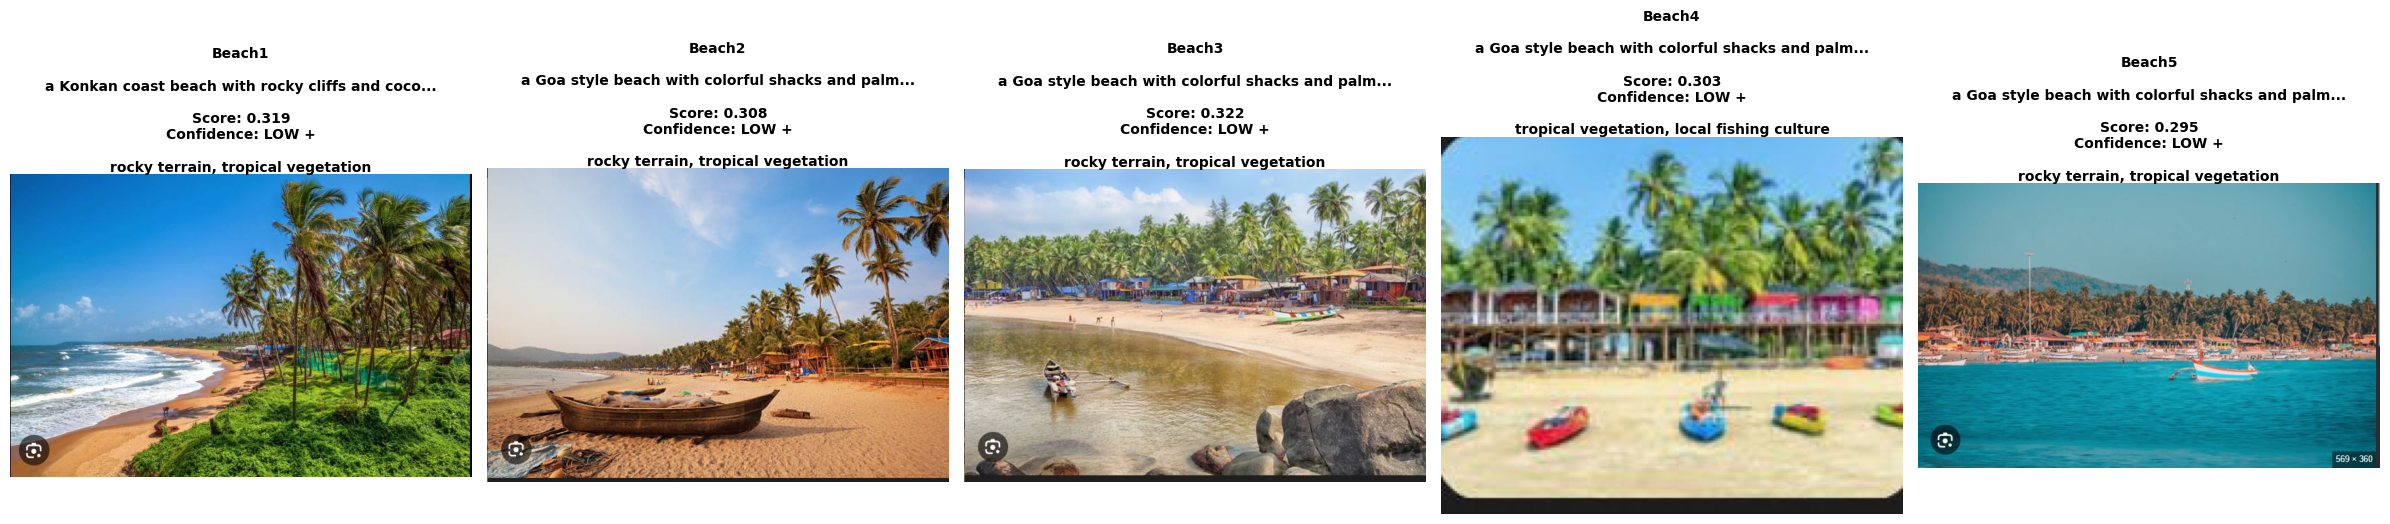


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Visualization downloaded successfully!

CREATING BATCH STATISTICS VISUALIZATION

  Saving batch statistics to: step1_batch_statistics.png
  File size: 154.44 KB

--------------------------------------------------------------------------------
Displaying batch statistics...
--------------------------------------------------------------------------------


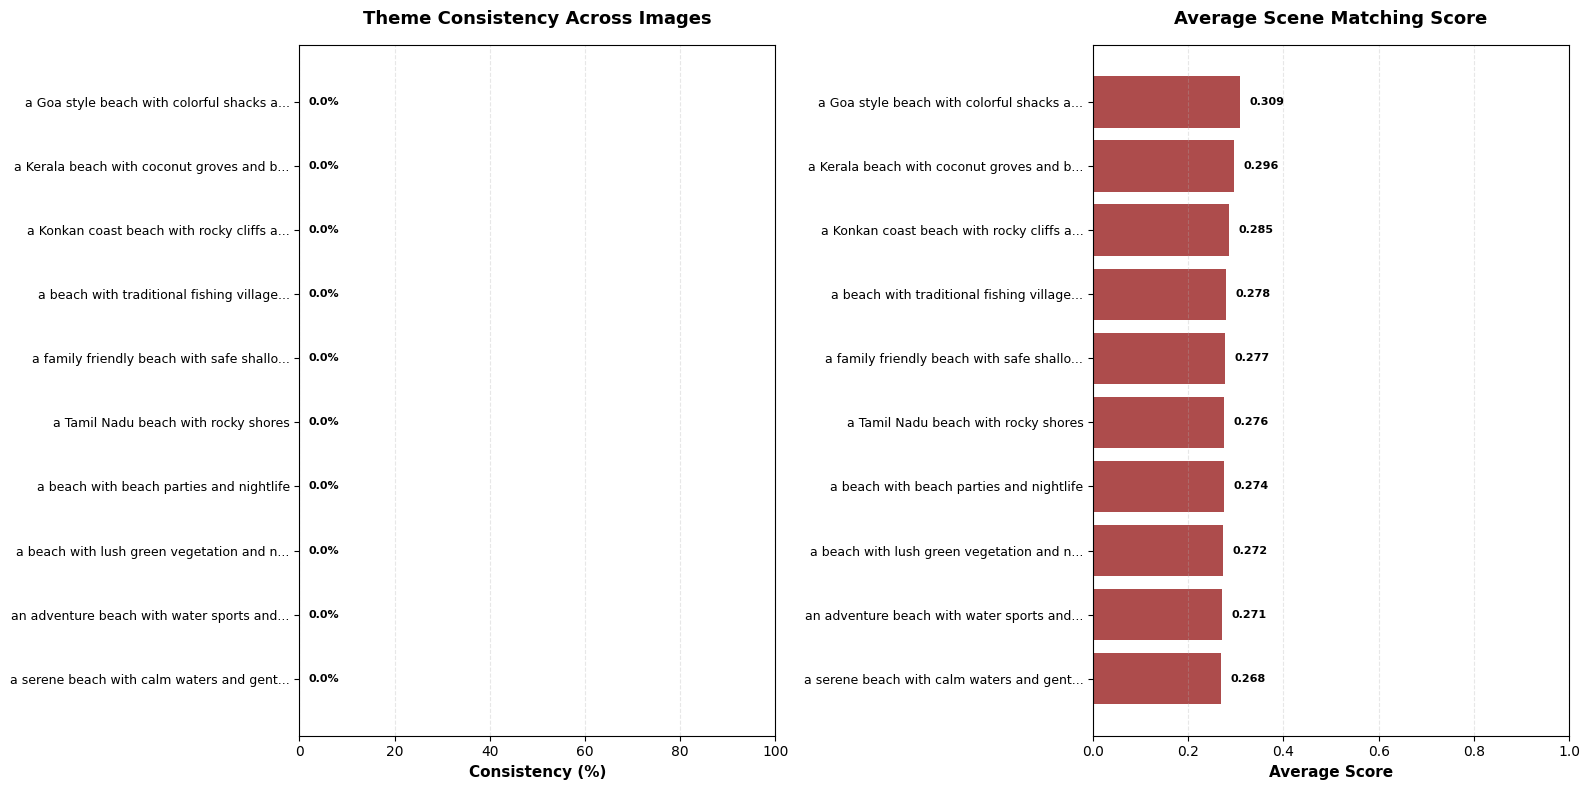


--------------------------------------------------------------------------------
--------------------------------------------------------------------------------


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Batch statistics visualization downloaded!

VISUALIZATION COMPLETE

Generated visualizations:
  1. step1_visualization.png - Image results with predictions
  2. step1_batch_statistics.png - Theme consistency charts

These visualizations can be used for:
  - Presentations and reports
  - Documentation
  - Quick visual verification of results
  - Comparison across different image sets

STEP 1: IMAGE ANALYSIS - ALL TASKS COMPLETE

What you have accomplished:
  1. Uploaded and validated images
  2. Performed CLIP-based scene classification
  3. Extracted visual features and color statistics
  4. Computed batch statistics and theme consistency
  5. Saved results to JSON format
  6. Created visualizations

Output files:
  - step1_analysis_results.json (complete data)
  - step1_analysis_summary.txt (human-readable summary)
  - step1_visualization.png (image results)
  - step1_batch_statistics.png (consistency charts)

Next Steps:
  - Review all downloaded files
  - Proceed to Step 2: Theme E

In [18]:
print("="*80)
print("VISUALIZATION: Creating graphical representation of results")
print("="*80)

# Verify results exist
if 'analysis_results' not in locals() or analysis_results is None:
    print("\nERROR: No analysis results found")
    print("Please run Cell 10 first to perform analysis.")
    print("="*80)
elif not analysis_results.get('success', False):
    print(f"\nERROR: Cannot visualize failed analysis")
    print(f"Reason: {analysis_results.get('error', 'Unknown error')}")
    print("="*80)
elif 'image_files' not in locals() or not image_files:
    print("\nERROR: Original image files not found")
    print("Please ensure Cell 9 was run successfully.")
    print("="*80)
else:
    print("\nPreparing visualization...")

    # Filter successful analyses
    successful_images = [
        img_file for img_file in image_files
        if analysis_results['per_image_analysis'][img_file['image_id']].get('success', False)
    ]

    if not successful_images:
        print("\nERROR: No successful analyses to visualize")
        print("="*80)
    else:
        num_images = len(successful_images)
        print(f"  Creating visualization for {num_images} image(s)...")

        # Calculate figure size
        fig_width = min(6 * num_images, 24)  # Max 24 inches wide
        fig_height = 8

        # Create figure and axes
        fig, axes = plt.subplots(1, num_images, figsize=(fig_width, fig_height))

        # Handle single image case (axes is not a list)
        if num_images == 1:
            axes = [axes]

        # Plot each image
        for idx, img_file in enumerate(successful_images):
            img_id = img_file['image_id']
            analysis = analysis_results['per_image_analysis'][img_id]

            # Load and display image
            img = Image.open(io.BytesIO(img_file['image_bytes']))
            axes[idx].imshow(img)
            axes[idx].axis('off')

            # Get top prediction
            top_scene = analysis['top_scenes'][0]
            confidence = analysis['confidence']

            # Create confidence indicator
            if confidence == 'high':
                confidence_symbol = "+++"
                confidence_color = 'green'
            elif confidence == 'medium':
                confidence_symbol = "++"
                confidence_color = 'orange'
            else:
                confidence_symbol = "+"
                confidence_color = 'red'

            # Truncate long prompts
            prompt_text = top_scene['prompt']
            if len(prompt_text) > 50:
                prompt_text = prompt_text[:47] + "..."

            # Create title text
            title_lines = []
            title_lines.append(f"{img_id}")
            title_lines.append("")
            title_lines.append(f"{prompt_text}")
            title_lines.append("")
            title_lines.append(f"Score: {top_scene['score']:.3f}")
            title_lines.append(f"Confidence: {confidence.upper()} {confidence_symbol}")

            # Add characteristics if available
            if analysis['visual_descriptors']['characteristics']:
                title_lines.append("")
                char_text = ", ".join(analysis['visual_descriptors']['characteristics'][:2])
                if len(char_text) > 50:
                    char_text = char_text[:47] + "..."
                title_lines.append(f"{char_text}")

            title_text = "\n".join(title_lines)

            # Set title with appropriate styling
            axes[idx].set_title(
                title_text,
                fontsize=10,
                fontweight='bold',
                pad=15,
                verticalalignment='top'
            )

        # Adjust layout
        plt.tight_layout()

        # Save visualization
        output_viz_file = Config.OUTPUT_VISUALIZATION_FILE
        print(f"  Saving to file: {output_viz_file}")

        plt.savefig(
            output_viz_file,
            dpi=Config.VISUALIZATION_DPI,
            bbox_inches='tight',
            facecolor='white',
            edgecolor='none'
        )

        # Get file size
        viz_file_size_bytes = os.path.getsize(output_viz_file)
        viz_file_size_kb = viz_file_size_bytes / 1024

        print("\n" + "="*80)
        print("VISUALIZATION CREATED")
        print("="*80)
        print(f"\nFile: {output_viz_file}")
        print(f"Size: {viz_file_size_kb:.2f} KB")
        print(f"Resolution: {Config.VISUALIZATION_DPI} DPI")
        print(f"Images: {num_images}")

        # Display in notebook
        print("\n" + "-"*80)
        print("Displaying visualization...")
        print("-"*80)
        plt.show()

        # Download file
        print("\n" + "-"*80)
        print("Downloading visualization to your computer...")
        print("-"*80)

        files.download(output_viz_file)

        print("\nVisualization downloaded successfully!")

        # Create additional visualizations if batch statistics available
        if num_images > 1 and analysis_results.get('batch_statistics'):
            print("\n" + "="*80)
            print("CREATING BATCH STATISTICS VISUALIZATION")
            print("="*80)

            stats = analysis_results['batch_statistics']

            # Extract top 10 themes
            theme_items = list(stats['theme_consistency'].items())[:10]
            theme_names = [item[0][:40] + "..." if len(item[0]) > 40 else item[0]
                          for item in theme_items]
            consistencies = [item[1]['consistency'] * 100 for item in theme_items]
            avg_scores = [item[1]['avg_score'] for item in theme_items]

            # Create figure with two subplots
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

            # Plot 1: Consistency bars
            y_pos = np.arange(len(theme_names))
            colors1 = ['green' if c >= 70 else 'orange' if c >= 40 else 'red'
                      for c in consistencies]

            ax1.barh(y_pos, consistencies, color=colors1, alpha=0.7)
            ax1.set_yticks(y_pos)
            ax1.set_yticklabels(theme_names, fontsize=9)
            ax1.set_xlabel('Consistency (%)', fontsize=11, fontweight='bold')
            ax1.set_title('Theme Consistency Across Images', fontsize=13, fontweight='bold', pad=15)
            ax1.set_xlim(0, 100)
            ax1.grid(axis='x', alpha=0.3, linestyle='--')
            ax1.invert_yaxis()

            # Add value labels
            for i, (pos, val) in enumerate(zip(y_pos, consistencies)):
                ax1.text(val + 2, pos, f'{val:.1f}%',
                        va='center', fontsize=8, fontweight='bold')

            # Plot 2: Average scores
            colors2 = ['darkgreen' if s >= 0.7 else 'darkorange' if s >= 0.5 else 'darkred'
                      for s in avg_scores]

            ax2.barh(y_pos, avg_scores, color=colors2, alpha=0.7)
            ax2.set_yticks(y_pos)
            ax2.set_yticklabels(theme_names, fontsize=9)
            ax2.set_xlabel('Average Score', fontsize=11, fontweight='bold')
            ax2.set_title('Average Scene Matching Score', fontsize=13, fontweight='bold', pad=15)
            ax2.set_xlim(0, 1.0)
            ax2.grid(axis='x', alpha=0.3, linestyle='--')
            ax2.invert_yaxis()

            # Add value labels
            for i, (pos, val) in enumerate(zip(y_pos, avg_scores)):
                ax2.text(val + 0.02, pos, f'{val:.3f}',
                        va='center', fontsize=8, fontweight='bold')

            plt.tight_layout()

            # Save batch statistics visualization
            batch_viz_file = "step1_batch_statistics.png"
            print(f"\n  Saving batch statistics to: {batch_viz_file}")

            plt.savefig(
                batch_viz_file,
                dpi=Config.VISUALIZATION_DPI,
                bbox_inches='tight',
                facecolor='white',
                edgecolor='none'
            )

            # Get file size
            batch_viz_size_bytes = os.path.getsize(batch_viz_file)
            batch_viz_size_kb = batch_viz_size_bytes / 1024

            print(f"  File size: {batch_viz_size_kb:.2f} KB")

            # Display in notebook
            print("\n" + "-"*80)
            print("Displaying batch statistics...")
            print("-"*80)
            plt.show()

            # Download file
            print("\n" + "-"*80)
            print("Downloading batch statistics visualization...")
            print("-"*80)

            files.download(batch_viz_file)

            print("\nBatch statistics visualization downloaded!")

        print("\n" + "="*80)
        print("VISUALIZATION COMPLETE")
        print("="*80)
        print("\nGenerated visualizations:")
        print(f"  1. {output_viz_file} - Image results with predictions")

        if num_images > 1 and analysis_results.get('batch_statistics'):
            print(f"  2. step1_batch_statistics.png - Theme consistency charts")

        print("\nThese visualizations can be used for:")
        print("  - Presentations and reports")
        print("  - Documentation")
        print("  - Quick visual verification of results")
        print("  - Comparison across different image sets")

        print("\n" + "="*80)
        print("STEP 1: IMAGE ANALYSIS - ALL TASKS COMPLETE")
        print("="*80)
        print("\nWhat you have accomplished:")
        print("  1. Uploaded and validated images")
        print("  2. Performed CLIP-based scene classification")
        print("  3. Extracted visual features and color statistics")
        print("  4. Computed batch statistics and theme consistency")
        print("  5. Saved results to JSON format")
        print("  6. Created visualizations")

        print("\nOutput files:")
        print("  - step1_analysis_results.json (complete data)")
        print("  - step1_analysis_summary.txt (human-readable summary)")
        print("  - step1_visualization.png (image results)")
        if num_images > 1 and analysis_results.get('batch_statistics'):
            print("  - step1_batch_statistics.png (consistency charts)")

        print("\nNext Steps:")
        print("  - Review all downloaded files")
        print("  - Proceed to Step 2: Theme Extraction and Aggregation")
        print("  - Use step1_analysis_results.json as input for Step 2")

        print("\n" + "="*80)
